In [177]:
import os 
import IPython.display as ipd
import numpy as np
import librosa
import librosa.display
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
import pickle
import hashlib

In [2]:
def get_files(dir_path):
    files = []
    for entry in os.scandir(dir_path):
        if entry.name.endswith('.wav'):
            path = os.path.join(dir_path,entry.name)
            files.append(path)
    return files
        
def get_file_name(file):
    name = file.split('\\')
    return name[-1][0:-4]

def get_answers(targets, queries):
    answers = dict()
    for query in queries:
        query_name = get_file_name(query)
        for target in targets:
            target_name = get_file_name(target)
            if target_name in query_name:
                answers.update({query_name: target_name})    
    return answers

def play_audios(files, max_play=5):
    for i, f in enumerate(files):
        ipd.display(ipd.Audio(f))
        if(i == max_play-1):
            break
    

In [3]:
targetDir = 'database_recordings'
queryDir = 'query_recordings'
fingerprintDir = 'fingerprint'
evaluationDir = 'evaluation'
        
targets = get_files(targetDir)
queries = get_files(queryDir)

answers = get_answers(targets, queries)
        
play_audios(targets, max_play=2)
play_audios(queries, max_play=2)

answers

{'classical.00000-snippet-10-0': 'classical.00000',
 'classical.00000-snippet-10-10': 'classical.00000',
 'classical.00000-snippet-10-20': 'classical.00000',
 'classical.00003-snippet-10-0': 'classical.00003',
 'classical.00003-snippet-10-10': 'classical.00003',
 'classical.00003-snippet-10-20': 'classical.00003',
 'classical.00004-snippet-10-0': 'classical.00004',
 'classical.00004-snippet-10-10': 'classical.00004',
 'classical.00005-snippet-10-0': 'classical.00005',
 'classical.00005-snippet-10-10': 'classical.00005',
 'classical.00005-snippet-10-20': 'classical.00005',
 'classical.00009-snippet-10-0': 'classical.00009',
 'classical.00009-snippet-10-10': 'classical.00009',
 'classical.00009-snippet-10-20': 'classical.00009',
 'classical.00010-snippet-10-0': 'classical.00010',
 'classical.00010-snippet-10-10': 'classical.00010',
 'classical.00010-snippet-10-20': 'classical.00010',
 'classical.00011-snippet-10-0': 'classical.00011',
 'classical.00011-snippet-10-10': 'classical.00011',


In [208]:
min_distance = 8
threshold_rel = 0.05

def calculate_stft(file, n_fft=2048, plot=False):
    y, sr = librosa.load(file)
    signal = normalise(y)
    # compute and plot STFT spectrogram
    D = np.abs(librosa.stft(signal, n_fft=1024, window='hann', win_length=1024, hop_length=512))
    if plot:
        plt.figure(figsize=(10,5))
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear',
                                x_axis='time', cmap='gray_r', sr=sr)
    return D

def calculate_contellation_map(D, min_distance=10, threshold_rel=0.05, plot=False):
    # detect peaks from STFT and plot contellation map
    coordinates = peak_local_max(np.log(D), min_distance=min_distance, threshold_rel=threshold_rel, indices=False)
    if plot:
        plt.figure(figsize=(10,5))
        plt.imshow(coordinates, cmap=plt.cm.gray_r, origin='lower')
    
    return coordinates

def normalise(wave):
    wave = (wave - np.min(wave))/(np.max(wave) - np.min(wave))
    return wave

In [209]:
# evaluation
def relevance_function(rank_data, queries):
    relevance = []
    for data in rank_data:
        if get_file_name(targets[data[0]]) == queries:
            relevance.append(1)
        else:
            relevance.append(0)
    return np.array(relevance)


def get_precision(rank, relevance):
    precision = []
    for r in range(len(rank)):
        sigma = 0.0
        for r in range(r+1):
            sigma += relevance[r]
        precision.append(sigma/(r+1))
    return np.array(precision)

def get_recall(rank, relevance):
    recall = []
    
    for r in range(len(rank)):
        sigma = 0.0
        for r in range(r+1):
            sigma += relevance[r]
        recall.append(sigma/len(relevance[relevance==1]))
    return np.nan_to_num(np.array(recall))

def f_measure(rank, relevance):
    precision = get_precision(rank, relevance)
    recall = get_recall(rank, relevance)
    f = 2 * precision * recall / (precision + recall)
    return np.nan_to_num(f)

def MAP(rank, relevance):
    precision = get_precision(rank, relevance)
    p_hat_q = []
    for r in range(len(rank)):
        sigma = 0.0
        for r in range(r+1):
            sigma += relevance[r] * precision[r]
        p_hat_q.append(sigma/len(relevance[relevance==1]))
        
    p_hat = np.array(p_hat_q).mean()
    
    return np.nan_to_num(p_hat)

def max_f_measure(rank, relevance):
    f = f_measure(rank, relevance)
    return np.array(f).max()

def break_even_point(rank, relevance):
    precision = np.array(get_precision(rank, relevance))
    recall = np.array(get_recall(rank, relevance))
    index = np.where(precision == recall)
    return index, precision[index]

In [210]:
coordinates_targets = []
inverted_lists = []
for i, target in enumerate(targets):
    stft = calculate_stft(target)
    coordinates_targets.append(calculate_contellation_map(stft,min_distance=min_distance, threshold_rel=threshold_rel))
    print(f'contellation_map {i+1}/{len(targets)}')
# print(len(np.where(coordinates_targets[0]==True)[0]))

<ipython-input-208-8baa6068428e>:17: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coordinates = peak_local_max(np.log(D), min_distance=min_distance, threshold_rel=threshold_rel, indices=False)


contellation_map 1/200
contellation_map 2/200
contellation_map 3/200
contellation_map 4/200
contellation_map 5/200
contellation_map 6/200
contellation_map 7/200
contellation_map 8/200
contellation_map 9/200
contellation_map 10/200
contellation_map 11/200
contellation_map 12/200
contellation_map 13/200
contellation_map 14/200
contellation_map 15/200
contellation_map 16/200
contellation_map 17/200
contellation_map 18/200
contellation_map 19/200
contellation_map 20/200
contellation_map 21/200
contellation_map 22/200
contellation_map 23/200
contellation_map 24/200
contellation_map 25/200
contellation_map 26/200
contellation_map 27/200
contellation_map 28/200
contellation_map 29/200
contellation_map 30/200
contellation_map 31/200
contellation_map 32/200
contellation_map 33/200
contellation_map 34/200
contellation_map 35/200
contellation_map 36/200
contellation_map 37/200
contellation_map 38/200
contellation_map 39/200
contellation_map 40/200
contellation_map 41/200
contellation_map 42/200
c

<ipython-input-208-8baa6068428e>:17: RuntimeWarning: divide by zero encountered in log
  coordinates = peak_local_max(np.log(D), min_distance=min_distance, threshold_rel=threshold_rel, indices=False)


contellation_map 55/200
contellation_map 56/200
contellation_map 57/200
contellation_map 58/200
contellation_map 59/200
contellation_map 60/200
contellation_map 61/200
contellation_map 62/200
contellation_map 63/200
contellation_map 64/200
contellation_map 65/200
contellation_map 66/200
contellation_map 67/200
contellation_map 68/200
contellation_map 69/200
contellation_map 70/200
contellation_map 71/200
contellation_map 72/200
contellation_map 73/200
contellation_map 74/200
contellation_map 75/200
contellation_map 76/200
contellation_map 77/200
contellation_map 78/200
contellation_map 79/200
contellation_map 80/200
contellation_map 81/200
contellation_map 82/200
contellation_map 83/200
contellation_map 84/200
contellation_map 85/200
contellation_map 86/200
contellation_map 87/200
contellation_map 88/200
contellation_map 89/200
contellation_map 90/200
contellation_map 91/200
contellation_map 92/200
contellation_map 93/200
contellation_map 94/200
contellation_map 95/200
contellation_map

In [211]:
anchor_distance = 5
fanout = 28
target_address = dict()

def generate_target_hash(coordinates_targets, fanout=30, anchor_distance=10):
    target_address = dict()
    for song_id, coordinates in enumerate(coordinates_targets):
        print(f'Generating Hash {song_id+1}/{len(targets)}...')
        contellation = np.where(coordinates.T==True)
        for i in range(len(contellation[0]) - fanout - anchor_distance + 1):
            anchor_time = contellation[0][i]
            anchor_frequency = contellation[1][i]
            for j in range(fanout):
                time = contellation[0][i+j+anchor_distance]
                frequency = contellation[1][i+j+anchor_distance]
                hash_ = hashlib.sha256(str((anchor_frequency, frequency, time - anchor_time)).encode()).hexdigest()
                if target_address.__contains__(hash_):
                    value = target_address[hash_]
                    value.append((anchor_time, song_id))
                    target_address.update({hash_:value})
                else:
                    target_address.update({hash_:[(anchor_time, song_id)]})
    return target_address


In [212]:
target_address = generate_target_hash(coordinates_targets,fanout=fanout, anchor_distance=anchor_distance)
# for key in target_address.keys():
#     print(key, target_address[key])
#     break

Generating Hash 1/200...
Generating Hash 2/200...
Generating Hash 3/200...
Generating Hash 4/200...
Generating Hash 5/200...
Generating Hash 6/200...
Generating Hash 7/200...
Generating Hash 8/200...
Generating Hash 9/200...
Generating Hash 10/200...
Generating Hash 11/200...
Generating Hash 12/200...
Generating Hash 13/200...
Generating Hash 14/200...
Generating Hash 15/200...
Generating Hash 16/200...
Generating Hash 17/200...
Generating Hash 18/200...
Generating Hash 19/200...
Generating Hash 20/200...
Generating Hash 21/200...
Generating Hash 22/200...
Generating Hash 23/200...
Generating Hash 24/200...
Generating Hash 25/200...
Generating Hash 26/200...
Generating Hash 27/200...
Generating Hash 28/200...
Generating Hash 29/200...
Generating Hash 30/200...
Generating Hash 31/200...
Generating Hash 32/200...
Generating Hash 33/200...
Generating Hash 34/200...
Generating Hash 35/200...
Generating Hash 36/200...
Generating Hash 37/200...
Generating Hash 38/200...
Generating Hash 39/20

In [213]:
with open(os.path.join(fingerprintDir,'target_address.data'), 'wb') as f:
    pickle.dump(target_address, f)

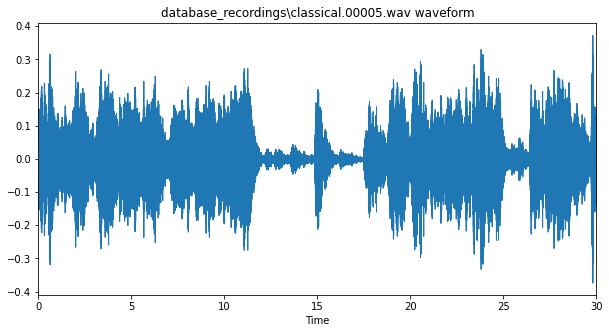

In [44]:
y, sr = librosa.load(targets[5])
plt.figure(figsize=(10,5))
librosa.display.waveplot(y)
plt.title(f'{targets[5]} waveform')
fig = plt.gcf()
fig.savefig('target waveform.png')

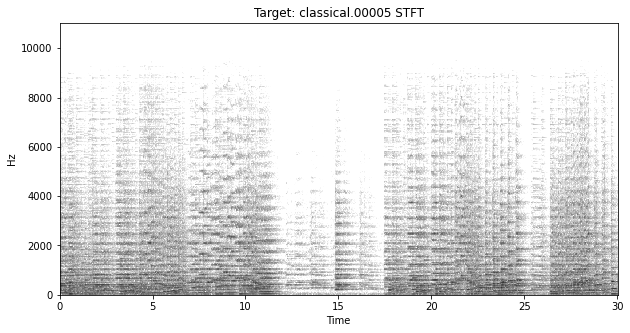

In [45]:
D = np.abs(librosa.stft(normalise(y), n_fft=1024, window='hann', win_length=1024, hop_length=512))
plt.figure(figsize=(10,5))
plt.xlabel('sample number')
plt.ylabel('frequency bins')
plt.title(f'Target: {get_file_name(targets[5])} STFT')

librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear',
                        x_axis='time', cmap='gray_r', sr=sr)
fig = plt.gcf()
fig.savefig('target stft.png')

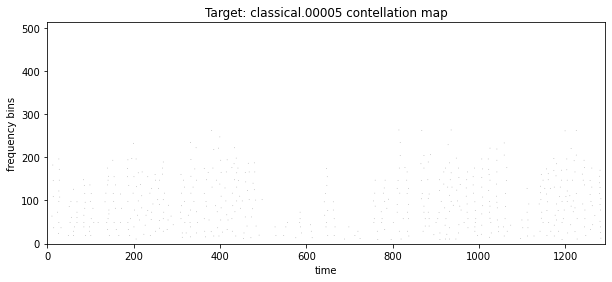

In [47]:
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('frequency bins')
plt.title(f'Target: {get_file_name(targets[5])} contellation map')

plt.imshow(coordinates_targets[5], cmap=plt.cm.gray_r, origin='lower')
fig = plt.gcf()
fig.savefig('target contellation map.png')

In [215]:
# query
coordinates_query = []
for i, q in enumerate(queries):
    stft = calculate_stft(q)
    coordinates_query.append(calculate_contellation_map(stft,min_distance=min_distance, threshold_rel=threshold_rel))
    print(f'contellation_map {i+1}/{len(queries)}')
# print(len(np.where(coordinates_query[3]==True)[0]))

<ipython-input-208-8baa6068428e>:17: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coordinates = peak_local_max(np.log(D), min_distance=min_distance, threshold_rel=threshold_rel, indices=False)


contellation_map 1/213
contellation_map 2/213
contellation_map 3/213
contellation_map 4/213
contellation_map 5/213
contellation_map 6/213
contellation_map 7/213
contellation_map 8/213
contellation_map 9/213
contellation_map 10/213
contellation_map 11/213
contellation_map 12/213
contellation_map 13/213
contellation_map 14/213
contellation_map 15/213
contellation_map 16/213
contellation_map 17/213
contellation_map 18/213
contellation_map 19/213
contellation_map 20/213
contellation_map 21/213
contellation_map 22/213
contellation_map 23/213
contellation_map 24/213
contellation_map 25/213
contellation_map 26/213
contellation_map 27/213
contellation_map 28/213
contellation_map 29/213
contellation_map 30/213
contellation_map 31/213
contellation_map 32/213
contellation_map 33/213
contellation_map 34/213
contellation_map 35/213
contellation_map 36/213
contellation_map 37/213
contellation_map 38/213
contellation_map 39/213
contellation_map 40/213
contellation_map 41/213
contellation_map 42/213
c

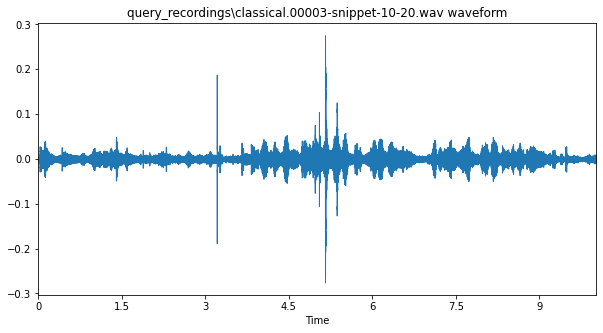

In [8]:
y, sr = librosa.load(queries[5])
plt.figure(figsize=(10,5))
librosa.display.waveplot(y)
plt.title(f'{queries[5]} waveform')
fig = plt.gcf()
fig.savefig('query waveform.png')

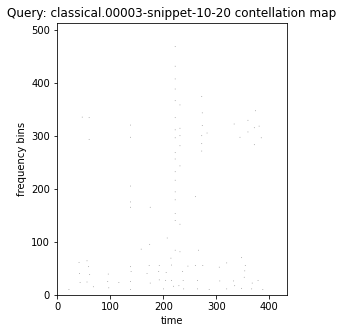

In [9]:
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('frequency bins')
plt.title(f'Query: {get_file_name(queries[5])} contellation map')
plt.imshow(coordinates_query[5], cmap=plt.cm.gray_r, origin='lower')
fig = plt.gcf()
fig.savefig('query contellation map.png')

In [216]:
with open(os.path.join(fingerprintDir,'target_address.data'), 'rb') as f:
    print(f'Loading fingerprints(target_address.data) in folder \'{fingerprintDir}\'...')
    target_address = pickle.load(f)

Loading fingerprints(target_address.data) in folder 'fingerprint'...


In [154]:
def generate_query_hash(coordinates_query, fanout=30, anchor_distance=10):
    for query_id, coordinates in enumerate(coordinates_query):
        print(f'Generating Query Hash {query_id+1}/{len(queries)}...')
        query_address = []
        contellation = np.where(coordinates.T==True)
        for i in range(len(contellation[0]) - fanout - anchor_distance + 1):
            anchor_time = contellation[0][i]
            anchor_frequency = contellation[1][i]
            for j in range(fanout):
                time = contellation[0][i+j+anchor_distance]
                frequency = contellation[1][i+j+anchor_distance]
                hash_ = hashlib.sha256(str((anchor_frequency, frequency, time - anchor_time)).encode()).hexdigest()
                query_address.append((anchor_time, hash_))
        yield query_address

def finger_match(coordinates_query, target_address, fanout=30, anchor_distance=10, top=3, evaluation=False, output_path =None):
    maps_query = []
    max_f_query = []
    if output_path:
        with open(output_path,'w+') as f:
            content = ''
            f.writelines(content)
            
    for query_id, query_list in enumerate(generate_query_hash(coordinates_query)):
        print(f'Query: {get_file_name(queries[query_id])}')
        cur_queries = answers[get_file_name(queries[query_id])]
                
        if len(query_list) == 0:
            if evaluation:
                maps_query.append(0)
                max_f_query.append(0)
            if output_path:
                with open(output_path,'a') as f:
                    content = f'{cur_queries}.wav\tno matches\n'
                    f.writelines(content)
            print('Sorry, the query finger is empty\n')
            continue

        indicator = dict() 

        for item in query_list:
            n, h = item
            if target_address.__contains__(h):
                l = np.array(target_address[h])
                time = np.dstack(l)[0][0] - n
                song_id = np.dstack(l)[0][1]
                keys = np.dstack((time, song_id))[0]
                for key in keys:
                    key = tuple(key)
                    if indicator.__contains__(key):
                        indicator.update({key: indicator[key]+1})
                    else:
                        indicator.update({key: 1})
        # results = sorted(indicator.items(), key=lambda x:x[1], reverse=True)
        # print(f'Results: {indicator.items()}\n')
        # filter(lambda x: x>=4, indicator)
        result_table = dict()
        for item in indicator.items():
            song_id = item[0][1]
            count_number = item[1]
            if result_table.__contains__(song_id):             
                result_table.update({song_id: result_table[song_id]+count_number})
            else:
                result_table.update({song_id: count_number})
        results = sorted(result_table.items(), key=lambda x:x[1], reverse=True)
        res = []
        for result in results[:top]:
            res.append(get_file_name(targets[result[0]]))
        print(res,'\n', results[:top],'\n')  
        
        if output_path:
            res1 = get_file_name(targets[results[0][0]])
            res2 = get_file_name(targets[results[1][0]])
            res3 = get_file_name(targets[results[2][0]])
            with open(output_path,'a') as f:
                content = f'{cur_queries}.wav\t{res1}.wav\t{res3}.wav\t{res3}.wav\n'
                f.writelines(content)
        if evaluation:
            relevance = relevance_function(results, cur_queries)
            map_ = MAP(results[:top], relevance)
            maps_query.append(map_)    

            fmax = max_f_measure(results[:top], relevance)
            max_f_query.append(fmax)

    return maps_query, max_f_query

In [226]:
maps_query, max_f_query = finger_match(coordinates_query, target_address, fanout=fanout, anchor_distance=anchor_distance,top=int(1e100), evaluation=True)

Generating Query Hash 1/213...
Query: classical.00000-snippet-10-0
Sorry, the query finger is empty

Generating Query Hash 2/213...
Query: classical.00000-snippet-10-10
['classical.00000', 'classical.00089', 'classical.00002', 'pop.00069', 'classical.00042', 'classical.00097', 'classical.00099', 'classical.00091', 'pop.00038', 'pop.00050', 'pop.00009', 'classical.00053', 'pop.00086', 'pop.00043', 'pop.00082', 'classical.00004', 'pop.00068', 'pop.00075', 'pop.00074', 'pop.00042', 'pop.00010', 'pop.00058', 'classical.00046', 'pop.00076', 'pop.00088', 'classical.00047', 'classical.00096', 'pop.00032', 'pop.00036', 'pop.00039', 'pop.00004', 'pop.00005', 'pop.00030', 'pop.00017', 'pop.00062', 'pop.00089', 'pop.00056', 'pop.00029', 'pop.00024', 'pop.00085', 'pop.00073', 'pop.00000', 'pop.00090', 'classical.00001', 'classical.00081', 'pop.00091', 'pop.00025', 'classical.00048', 'pop.00070', 'pop.00031', 'classical.00059', 'pop.00014', 'pop.00027', 'pop.00087', 'classical.00038', 'pop.00002', 

['classical.00099', 'classical.00089', 'classical.00059', 'classical.00061', 'classical.00042', 'classical.00002', 'classical.00046', 'pop.00003', 'classical.00053', 'pop.00069', 'classical.00056', 'classical.00081', 'pop.00037', 'classical.00060', 'classical.00000', 'classical.00097', 'pop.00033', 'classical.00068', 'pop.00094', 'classical.00087', 'classical.00090', 'classical.00004', 'classical.00049', 'classical.00028', 'pop.00058', 'classical.00085', 'pop.00015', 'classical.00092', 'pop.00087', 'pop.00062', 'classical.00005', 'classical.00001', 'pop.00085', 'classical.00082', 'pop.00010', 'classical.00015', 'classical.00096', 'pop.00023', 'pop.00022', 'pop.00031', 'pop.00004', 'pop.00057', 'pop.00068', 'classical.00014', 'pop.00098', 'classical.00023', 'classical.00093', 'pop.00091', 'pop.00090', 'classical.00045', 'pop.00078', 'pop.00086', 'classical.00003', 'pop.00067', 'pop.00071', 'classical.00069', 'classical.00024', 'pop.00024', 'classical.00070', 'classical.00091', 'classica

<ipython-input-209-843ca9f0b043>:34: RuntimeWarning: invalid value encountered in true_divide
  f = 2 * precision * recall / (precision + recall)
<ipython-input-209-843ca9f0b043>:44: RuntimeWarning: invalid value encountered in double_scalars
  p_hat_q.append(sigma/len(relevance[relevance==1]))
<ipython-input-209-843ca9f0b043>:28: RuntimeWarning: invalid value encountered in double_scalars
  recall.append(sigma/len(relevance[relevance==1]))


['classical.00056', 'pop.00024', 'pop.00070', 'classical.00096', 'pop.00078', 'classical.00082', 'pop.00027', 'pop.00080', 'pop.00058', 'pop.00047', 'pop.00051', 'classical.00004', 'classical.00061', 'classical.00081', 'classical.00007', 'classical.00053', 'pop.00048', 'pop.00067', 'pop.00071', 'pop.00064', 'classical.00065', 'classical.00050', 'classical.00024', 'classical.00013', 'pop.00003', 'classical.00074', 'pop.00099', 'pop.00016', 'pop.00073', 'pop.00084', 'pop.00074', 'pop.00068', 'pop.00061', 'classical.00068', 'classical.00014', 'classical.00001', 'classical.00048', 'classical.00038', 'classical.00094', 'classical.00000', 'classical.00054', 'pop.00039', 'pop.00050', 'classical.00052', 'pop.00009', 'classical.00079', 'classical.00099', 'classical.00026', 'classical.00066', 'classical.00086', 'classical.00005', 'classical.00093', 'pop.00020', 'classical.00085', 'pop.00000', 'classical.00073', 'pop.00011', 'classical.00030', 'classical.00059', 'pop.00013', 'pop.00001', 'classic

Generating Query Hash 9/213...
Query: classical.00005-snippet-10-0
['classical.00025', 'classical.00059', 'classical.00045', 'classical.00023', 'classical.00097', 'classical.00014', 'classical.00040', 'classical.00032', 'classical.00035', 'classical.00047', 'classical.00011', 'classical.00092', 'classical.00017', 'classical.00028', 'classical.00053', 'classical.00005', 'classical.00074', 'classical.00018', 'pop.00006', 'classical.00082', 'classical.00093', 'classical.00015', 'pop.00063', 'classical.00071', 'classical.00012', 'classical.00007', 'classical.00006', 'classical.00085', 'classical.00062', 'classical.00087', 'classical.00038', 'classical.00001', 'classical.00024', 'classical.00010', 'classical.00050', 'classical.00083', 'pop.00007', 'classical.00029', 'classical.00048', 'classical.00030', 'classical.00056', 'classical.00081', 'pop.00081', 'classical.00022', 'pop.00040', 'pop.00041', 'classical.00088', 'classical.00098', 'classical.00058', 'classical.00066', 'pop.00011', 'clas

Generating Query Hash 11/213...
Query: classical.00005-snippet-10-20
['classical.00005', 'classical.00097', 'classical.00025', 'classical.00012', 'classical.00011', 'classical.00093', 'classical.00054', 'classical.00042', 'classical.00085', 'classical.00024', 'classical.00030', 'pop.00063', 'classical.00056', 'classical.00045', 'classical.00008', 'classical.00081', 'classical.00072', 'classical.00014', 'classical.00076', 'classical.00069', 'classical.00092', 'classical.00061', 'classical.00068', 'classical.00006', 'classical.00046', 'classical.00038', 'classical.00059', 'classical.00020', 'classical.00003', 'classical.00073', 'classical.00050', 'classical.00010', 'classical.00074', 'classical.00027', 'classical.00017', 'pop.00041', 'classical.00004', 'classical.00058', 'classical.00096', 'classical.00001', 'classical.00086', 'classical.00088', 'classical.00009', 'pop.00081', 'pop.00003', 'classical.00023', 'classical.00026', 'classical.00000', 'classical.00016', 'classical.00098', 'cla

['classical.00061', 'classical.00085', 'classical.00024', 'classical.00056', 'classical.00046', 'classical.00096', 'classical.00002', 'classical.00068', 'classical.00049', 'classical.00082', 'classical.00097', 'classical.00028', 'classical.00069', 'classical.00025', 'classical.00001', 'pop.00079', 'classical.00071', 'classical.00073', 'classical.00012', 'classical.00081', 'classical.00013', 'classical.00058', 'classical.00000', 'classical.00047', 'classical.00099', 'classical.00011', 'classical.00038', 'classical.00090', 'classical.00029', 'classical.00057', 'classical.00072', 'classical.00084', 'classical.00009', 'classical.00094', 'pop.00065', 'classical.00045', 'classical.00004', 'classical.00022', 'pop.00007', 'classical.00059', 'classical.00042', 'classical.00098', 'pop.00003', 'classical.00076', 'classical.00074', 'pop.00063', 'classical.00070', 'classical.00060', 'classical.00017', 'classical.00027', 'classical.00054', 'classical.00037', 'classical.00010', 'classical.00007', 'cl

Generating Query Hash 16/213...
Query: classical.00010-snippet-10-10
['classical.00010', 'classical.00085', 'classical.00025', 'classical.00005', 'classical.00088', 'classical.00024', 'classical.00004', 'classical.00097', 'classical.00020', 'classical.00053', 'classical.00030', 'classical.00075', 'classical.00028', 'classical.00086', 'classical.00068', 'classical.00061', 'classical.00071', 'pop.00081', 'classical.00094', 'classical.00001', 'classical.00059', 'classical.00082', 'pop.00003', 'classical.00076', 'classical.00023', 'classical.00084', 'classical.00073', 'classical.00096', 'classical.00060', 'classical.00046', 'classical.00007', 'classical.00050', 'classical.00042', 'classical.00006', 'pop.00053', 'classical.00090', 'classical.00002', 'pop.00058', 'classical.00052', 'classical.00008', 'classical.00081', 'classical.00072', 'pop.00014', 'pop.00063', 'classical.00003', 'classical.00069', 'pop.00033', 'classical.00092', 'classical.00093', 'classical.00047', 'pop.00079', 'classica

Generating Query Hash 19/213...
Query: classical.00011-snippet-10-10
['classical.00098', 'classical.00049', 'classical.00060', 'classical.00069', 'classical.00056', 'classical.00050', 'classical.00073', 'pop.00069', 'classical.00053', 'classical.00011', 'classical.00059', 'classical.00085', 'classical.00096', 'classical.00028', 'classical.00057', 'classical.00005', 'pop.00003', 'classical.00068', 'classical.00008', 'classical.00024', 'classical.00004', 'classical.00012', 'pop.00080', 'pop.00014', 'pop.00094', 'classical.00071', 'pop.00050', 'pop.00047', 'classical.00013', 'classical.00082', 'classical.00020', 'pop.00063', 'classical.00099', 'pop.00033', 'pop.00095', 'pop.00015', 'classical.00025', 'classical.00042', 'pop.00000', 'pop.00030', 'pop.00031', 'pop.00034', 'classical.00010', 'pop.00054', 'pop.00060', 'pop.00075', 'classical.00061', 'pop.00012', 'pop.00022', 'classical.00021', 'pop.00097', 'classical.00094', 'classical.00026', 'classical.00022', 'pop.00085', 'classical.00009'

['classical.00012', 'classical.00069', 'classical.00098', 'classical.00011', 'classical.00071', 'classical.00049', 'classical.00073', 'classical.00083', 'classical.00068', 'classical.00027', 'classical.00054', 'classical.00061', 'classical.00022', 'classical.00050', 'classical.00008', 'classical.00024', 'classical.00059', 'classical.00060', 'classical.00057', 'classical.00072', 'classical.00097', 'classical.00006', 'classical.00020', 'classical.00074', 'classical.00042', 'classical.00076', 'classical.00075', 'classical.00009', 'classical.00062', 'classical.00005', 'classical.00094', 'classical.00028', 'classical.00093', 'classical.00013', 'pop.00063', 'classical.00026', 'classical.00029', 'classical.00084', 'classical.00044', 'classical.00030', 'classical.00010', 'classical.00085', 'classical.00088', 'classical.00086', 'pop.00083', 'classical.00017', 'classical.00023', 'classical.00007', 'classical.00021', 'classical.00003', 'classical.00025', 'classical.00004', 'classical.00082', 'cla

Generating Query Hash 23/213...
Query: classical.00013-snippet-10-0
['classical.00056', 'classical.00013', 'classical.00096', 'classical.00053', 'classical.00085', 'classical.00024', 'classical.00028', 'classical.00014', 'classical.00042', 'classical.00029', 'pop.00003', 'classical.00061', 'classical.00094', 'classical.00046', 'classical.00059', 'classical.00068', 'classical.00097', 'classical.00026', 'classical.00082', 'classical.00069', 'classical.00049', 'classical.00057', 'classical.00027', 'classical.00073', 'pop.00000', 'classical.00000', 'pop.00087', 'classical.00084', 'classical.00099', 'classical.00071', 'classical.00098', 'classical.00025', 'classical.00058', 'pop.00019', 'pop.00090', 'classical.00052', 'pop.00065', 'classical.00005', 'pop.00085', 'pop.00069', 'classical.00004', 'classical.00012', 'classical.00072', 'classical.00070', 'classical.00030', 'classical.00087', 'pop.00014', 'classical.00074', 'pop.00007', 'classical.00010', 'pop.00086', 'classical.00047', 'pop.0001

Generating Query Hash 26/213...
Query: classical.00014-snippet-10-0
['pop.00023', 'pop.00055', 'pop.00093', 'pop.00020', 'classical.00056', 'pop.00037', 'pop.00069', 'pop.00090', 'pop.00048', 'pop.00027', 'pop.00098', 'pop.00025', 'pop.00018', 'pop.00078', 'pop.00009', 'pop.00084', 'pop.00021', 'pop.00070', 'pop.00002', 'pop.00061', 'pop.00091', 'pop.00088', 'pop.00031', 'pop.00095', 'pop.00043', 'pop.00087', 'pop.00017', 'pop.00051', 'classical.00028', 'classical.00059', 'classical.00014', 'pop.00054', 'pop.00060', 'pop.00057', 'classical.00053', 'pop.00086', 'pop.00034', 'pop.00015', 'pop.00067', 'pop.00071', 'classical.00060', 'pop.00010', 'classical.00024', 'pop.00074', 'pop.00089', 'pop.00042', 'pop.00066', 'pop.00075', 'pop.00022', 'pop.00085', 'pop.00047', 'pop.00029', 'pop.00033', 'pop.00013', 'pop.00077', 'pop.00003', 'pop.00030', 'pop.00014', 'pop.00058', 'classical.00096', 'pop.00045', 'pop.00026', 'classical.00054', 'pop.00080', 'pop.00072', 'pop.00056', 'pop.00024', 'pop.0

['classical.00099', 'classical.00053', 'pop.00079', 'pop.00069', 'classical.00002', 'pop.00010', 'pop.00075', 'classical.00046', 'classical.00090', 'classical.00096', 'pop.00027', 'classical.00089', 'pop.00014', 'classical.00091', 'classical.00048', 'pop.00005', 'pop.00022', 'classical.00060', 'classical.00042', 'pop.00043', 'pop.00081', 'pop.00017', 'pop.00021', 'classical.00081', 'pop.00055', 'pop.00054', 'pop.00060', 'pop.00072', 'classical.00000', 'pop.00076', 'pop.00074', 'pop.00031', 'pop.00090', 'pop.00056', 'pop.00058', 'pop.00029', 'pop.00086', 'pop.00038', 'pop.00016', 'pop.00015', 'pop.00019', 'pop.00044', 'pop.00073', 'classical.00076', 'pop.00062', 'classical.00052', 'classical.00023', 'classical.00059', 'pop.00030', 'pop.00068', 'classical.00028', 'pop.00070', 'classical.00045', 'pop.00028', 'pop.00039', 'classical.00015', 'pop.00035', 'pop.00012', 'pop.00037', 'pop.00089', 'pop.00032', 'pop.00093', 'pop.00083', 'pop.00059', 'classical.00098', 'classical.00005', 'pop.0002

Generating Query Hash 30/213...
Query: classical.00015-snippet-10-10
['classical.00099', 'classical.00015', 'classical.00017', 'classical.00060', 'classical.00045', 'pop.00010', 'classical.00081', 'classical.00093', 'classical.00014', 'classical.00082', 'classical.00049', 'classical.00016', 'classical.00069', 'classical.00047', 'classical.00056', 'classical.00029', 'classical.00068', 'classical.00004', 'classical.00089', 'classical.00087', 'classical.00096', 'classical.00028', 'classical.00058', 'classical.00059', 'pop.00041', 'classical.00025', 'classical.00001', 'classical.00094', 'classical.00038', 'classical.00090', 'classical.00027', 'classical.00000', 'pop.00026', 'classical.00073', 'classical.00002', 'classical.00024', 'classical.00061', 'classical.00074', 'classical.00013', 'pop.00007', 'classical.00092', 'classical.00071', 'classical.00044', 'classical.00023', 'classical.00003', 'classical.00037', 'classical.00042', 'pop.00074', 'classical.00075', 'pop.00003', 'classical.00088

Generating Query Hash 34/213...
Query: classical.00019-snippet-10-20
['classical.00002', 'classical.00042', 'classical.00056', 'classical.00025', 'classical.00089', 'classical.00099', 'classical.00069', 'classical.00053', 'classical.00059', 'classical.00045', 'classical.00081', 'classical.00028', 'classical.00073', 'classical.00060', 'classical.00024', 'classical.00068', 'pop.00010', 'classical.00096', 'classical.00022', 'classical.00049', 'classical.00092', 'classical.00091', 'classical.00050', 'classical.00093', 'classical.00004', 'classical.00057', 'classical.00097', 'pop.00003', 'pop.00012', 'pop.00083', 'classical.00000', 'classical.00001', 'classical.00005', 'classical.00030', 'pop.00053', 'classical.00082', 'classical.00029', 'classical.00061', 'classical.00085', 'pop.00033', 'classical.00010', 'classical.00046', 'pop.00072', 'pop.00065', 'pop.00082', 'classical.00020', 'pop.00081', 'classical.00084', 'pop.00006', 'pop.00079', 'classical.00026', 'classical.00058', 'classical.000

Generating Query Hash 37/213...
Query: classical.00020-snippet-10-20
['classical.00020', 'classical.00076', 'classical.00086', 'classical.00044', 'classical.00088', 'classical.00023', 'classical.00099', 'pop.00083', 'classical.00009', 'classical.00005', 'classical.00007', 'classical.00085', 'classical.00042', 'classical.00069', 'classical.00073', 'classical.00019', 'classical.00008', 'classical.00068', 'classical.00006', 'classical.00090', 'classical.00049', 'classical.00059', 'classical.00054', 'pop.00094', 'classical.00024', 'pop.00079', 'classical.00098', 'classical.00082', 'classical.00060', 'classical.00004', 'pop.00012', 'pop.00014', 'classical.00053', 'classical.00084', 'classical.00046', 'classical.00057', 'classical.00074', 'classical.00075', 'classical.00015', 'classical.00030', 'classical.00071', 'classical.00025', 'classical.00002', 'pop.00063', 'classical.00022', 'classical.00093', 'classical.00010', 'classical.00045', 'classical.00021', 'classical.00072', 'pop.00065', 'po

['classical.00024', 'classical.00056', 'classical.00076', 'classical.00069', 'classical.00044', 'classical.00073', 'classical.00053', 'classical.00072', 'classical.00061', 'classical.00068', 'classical.00007', 'classical.00050', 'classical.00005', 'classical.00025', 'classical.00096', 'classical.00099', 'classical.00022', 'classical.00020', 'classical.00028', 'classical.00010', 'classical.00071', 'classical.00006', 'classical.00042', 'classical.00085', 'pop.00063', 'pop.00083', 'pop.00003', 'classical.00049', 'classical.00023', 'classical.00084', 'classical.00009', 'classical.00013', 'classical.00086', 'classical.00008', 'classical.00059', 'classical.00082', 'classical.00088', 'classical.00094', 'classical.00029', 'classical.00019', 'classical.00057', 'classical.00097', 'classical.00074', 'pop.00065', 'classical.00060', 'classical.00027', 'classical.00003', 'pop.00079', 'classical.00002', 'classical.00030', 'classical.00046', 'classical.00012', 'classical.00001', 'classical.00021', 'po

Generating Query Hash 42/213...
Query: classical.00025-snippet-10-10
['classical.00025', 'classical.00053', 'classical.00024', 'classical.00010', 'classical.00005', 'classical.00096', 'classical.00008', 'classical.00073', 'classical.00042', 'classical.00057', 'classical.00085', 'classical.00022', 'classical.00045', 'classical.00030', 'classical.00093', 'pop.00003', 'classical.00069', 'classical.00074', 'classical.00020', 'classical.00009', 'classical.00007', 'classical.00076', 'classical.00046', 'classical.00013', 'classical.00004', 'classical.00060', 'classical.00003', 'classical.00068', 'classical.00071', 'classical.00098', 'classical.00061', 'classical.00056', 'classical.00097', 'classical.00050', 'classical.00044', 'pop.00007', 'classical.00094', 'pop.00065', 'classical.00026', 'classical.00029', 'classical.00000', 'classical.00081', 'classical.00059', 'pop.00083', 'classical.00001', 'classical.00014', 'classical.00049', 'classical.00084', 'classical.00082', 'classical.00021', 'cla

Generating Query Hash 44/213...
Query: classical.00034-snippet-10-0
['classical.00034', 'classical.00098', 'classical.00053', 'classical.00024', 'classical.00025', 'classical.00096', 'classical.00060', 'classical.00008', 'classical.00042', 'pop.00014', 'classical.00004', 'classical.00046', 'classical.00099', 'classical.00069', 'classical.00085', 'classical.00093', 'classical.00022', 'classical.00097', 'classical.00005', 'classical.00071', 'classical.00089', 'classical.00002', 'classical.00007', 'classical.00003', 'classical.00045', 'pop.00065', 'classical.00073', 'classical.00012', 'pop.00081', 'pop.00069', 'classical.00081', 'classical.00050', 'classical.00056', 'classical.00059', 'classical.00057', 'classical.00028', 'pop.00012', 'classical.00010', 'pop.00070', 'classical.00091', 'classical.00030', 'classical.00083', 'pop.00072', 'pop.00003', 'classical.00037', 'classical.00074', 'classical.00051', 'pop.00079', 'pop.00040', 'pop.00063', 'classical.00088', 'classical.00090', 'pop.0008

Generating Query Hash 46/213...
Query: classical.00034-snippet-10-20
['classical.00056', 'classical.00004', 'classical.00046', 'classical.00059', 'classical.00099', 'classical.00049', 'classical.00053', 'classical.00042', 'classical.00008', 'classical.00002', 'classical.00085', 'classical.00060', 'classical.00082', 'classical.00069', 'classical.00093', 'classical.00058', 'classical.00034', 'classical.00005', 'classical.00098', 'classical.00096', 'pop.00010', 'classical.00045', 'pop.00040', 'classical.00068', 'classical.00030', 'classical.00028', 'classical.00097', 'classical.00071', 'classical.00083', 'classical.00074', 'pop.00033', 'pop.00063', 'pop.00079', 'pop.00014', 'classical.00003', 'classical.00007', 'classical.00037', 'pop.00083', 'classical.00029', 'classical.00073', 'classical.00000', 'classical.00094', 'classical.00076', 'classical.00052', 'classical.00047', 'pop.00003', 'pop.00075', 'classical.00024', 'classical.00013', 'pop.00008', 'classical.00025', 'classical.00038', 'p

Generating Query Hash 49/213...
Query: classical.00035-snippet-10-20
['classical.00035', 'classical.00042', 'classical.00002', 'classical.00037', 'classical.00097', 'classical.00056', 'classical.00096', 'classical.00004', 'pop.00010', 'classical.00000', 'classical.00098', 'classical.00053', 'classical.00025', 'classical.00059', 'classical.00099', 'classical.00081', 'classical.00028', 'classical.00089', 'classical.00047', 'classical.00061', 'classical.00038', 'classical.00045', 'classical.00068', 'classical.00046', 'classical.00024', 'classical.00029', 'classical.00082', 'classical.00091', 'classical.00070', 'classical.00069', 'classical.00060', 'classical.00085', 'pop.00003', 'pop.00069', 'classical.00027', 'classical.00083', 'classical.00030', 'classical.00087', 'classical.00015', 'classical.00048', 'classical.00093', 'classical.00058', 'pop.00065', 'pop.00081', 'pop.00079', 'pop.00007', 'classical.00017', 'classical.00094', 'classical.00014', 'classical.00051', 'classical.00071', 'cl

Generating Query Hash 52/213...
Query: classical.00039-snippet-10-20
['classical.00042', 'classical.00090', 'classical.00081', 'classical.00097', 'classical.00093', 'classical.00024', 'classical.00059', 'classical.00054', 'pop.00063', 'classical.00002', 'classical.00085', 'classical.00013', 'classical.00008', 'classical.00030', 'pop.00081', 'classical.00099', 'classical.00082', 'classical.00028', 'pop.00053', 'classical.00004', 'classical.00060', 'classical.00088', 'classical.00000', 'classical.00025', 'classical.00050', 'classical.00040', 'classical.00073', 'pop.00033', 'classical.00011', 'classical.00061', 'classical.00053', 'classical.00006', 'classical.00070', 'classical.00049', 'classical.00086', 'pop.00003', 'pop.00079', 'classical.00068', 'classical.00038', 'pop.00099', 'classical.00005', 'pop.00014', 'classical.00022', 'classical.00091', 'classical.00096', 'classical.00089', 'classical.00074', 'pop.00010', 'classical.00010', 'classical.00023', 'classical.00075', 'classical.0002

['classical.00069', 'classical.00042', 'classical.00020', 'classical.00097', 'classical.00053', 'classical.00068', 'classical.00054', 'classical.00096', 'classical.00059', 'classical.00085', 'classical.00061', 'pop.00063', 'classical.00070', 'classical.00044', 'classical.00008', 'classical.00012', 'classical.00010', 'classical.00093', 'classical.00006', 'classical.00005', 'classical.00002', 'classical.00000', 'classical.00083', 'classical.00060', 'classical.00073', 'classical.00074', 'classical.00017', 'classical.00045', 'pop.00040', 'classical.00014', 'classical.00009', 'classical.00048', 'classical.00011', 'classical.00058', 'classical.00046', 'classical.00004', 'classical.00037', 'classical.00089', 'classical.00007', 'classical.00099', 'classical.00098', 'classical.00024', 'classical.00025', 'classical.00013', 'pop.00079', 'classical.00029', 'classical.00081', 'pop.00012', 'classical.00086', 'pop.00007', 'classical.00091', 'classical.00071', 'classical.00050', 'classical.00021', 'cl

Generating Query Hash 56/213...
Query: classical.00044-snippet-10-10
['classical.00020', 'classical.00076', 'classical.00044', 'pop.00079', 'classical.00049', 'classical.00024', 'classical.00088', 'classical.00005', 'classical.00009', 'classical.00007', 'classical.00069', 'classical.00050', 'classical.00085', 'classical.00099', 'classical.00086', 'classical.00073', 'classical.00023', 'classical.00006', 'classical.00043', 'classical.00084', 'classical.00082', 'classical.00045', 'classical.00021', 'pop.00083', 'classical.00048', 'pop.00016', 'classical.00056', 'classical.00008', 'classical.00002', 'pop.00081', 'classical.00093', 'classical.00098', 'classical.00068', 'classical.00030', 'pop.00063', 'classical.00072', 'classical.00094', 'classical.00081', 'classical.00022', 'pop.00017', 'classical.00028', 'pop.00065', 'classical.00071', 'classical.00060', 'pop.00064', 'classical.00010', 'classical.00090', 'classical.00053', 'classical.00059', 'classical.00019', 'classical.00025', 'pop.0000

Generating Query Hash 58/213...
Query: classical.00045-snippet-10-0
['classical.00045', 'classical.00097', 'classical.00093', 'classical.00042', 'classical.00002', 'classical.00004', 'classical.00049', 'classical.00059', 'classical.00081', 'classical.00069', 'classical.00092', 'classical.00000', 'classical.00099', 'classical.00085', 'classical.00076', 'classical.00050', 'classical.00071', 'classical.00047', 'classical.00089', 'classical.00068', 'classical.00024', 'classical.00094', 'classical.00091', 'classical.00008', 'classical.00015', 'classical.00017', 'classical.00020', 'classical.00087', 'classical.00057', 'classical.00005', 'pop.00010', 'classical.00073', 'classical.00022', 'classical.00029', 'pop.00081', 'classical.00096', 'classical.00061', 'classical.00075', 'classical.00046', 'classical.00060', 'classical.00083', 'classical.00084', 'classical.00098', 'classical.00056', 'pop.00014', 'classical.00028', 'classical.00001', 'classical.00027', 'classical.00012', 'classical.00044',

Generating Query Hash 60/213...
Query: classical.00045-snippet-10-20
['classical.00045', 'classical.00097', 'classical.00047', 'classical.00042', 'classical.00002', 'classical.00000', 'classical.00059', 'classical.00081', 'classical.00056', 'classical.00053', 'classical.00089', 'classical.00099', 'classical.00092', 'classical.00093', 'classical.00016', 'classical.00061', 'classical.00087', 'classical.00025', 'classical.00001', 'classical.00085', 'classical.00021', 'pop.00003', 'classical.00050', 'classical.00029', 'classical.00026', 'pop.00079', 'classical.00014', 'classical.00004', 'classical.00096', 'classical.00069', 'classical.00024', 'classical.00091', 'classical.00027', 'classical.00015', 'classical.00073', 'classical.00075', 'classical.00008', 'classical.00057', 'classical.00009', 'classical.00071', 'classical.00028', 'classical.00046', 'classical.00003', 'classical.00058', 'classical.00082', 'classical.00013', 'classical.00068', 'classical.00049', 'classical.00017', 'classical.

['classical.00049', 'classical.00056', 'classical.00069', 'classical.00061', 'classical.00028', 'classical.00068', 'classical.00085', 'classical.00099', 'classical.00073', 'classical.00059', 'classical.00098', 'classical.00082', 'classical.00013', 'classical.00029', 'classical.00058', 'classical.00060', 'classical.00094', 'classical.00017', 'classical.00083', 'classical.00097', 'classical.00006', 'classical.00050', 'classical.00084', 'pop.00065', 'classical.00003', 'classical.00076', 'classical.00012', 'classical.00071', 'classical.00026', 'classical.00024', 'classical.00042', 'classical.00027', 'classical.00074', 'pop.00003', 'classical.00044', 'classical.00011', 'classical.00096', 'classical.00075', 'classical.00022', 'classical.00070', 'classical.00020', 'pop.00063', 'classical.00014', 'classical.00088', 'classical.00015', 'classical.00057', 'classical.00016', 'classical.00087', 'classical.00072', 'classical.00009', 'classical.00023', 'pop.00011', 'classical.00037', 'pop.00033', 'cl

['classical.00049', 'classical.00069', 'classical.00056', 'classical.00073', 'classical.00061', 'classical.00085', 'classical.00022', 'classical.00053', 'classical.00084', 'classical.00068', 'classical.00024', 'classical.00097', 'classical.00050', 'classical.00006', 'classical.00012', 'classical.00042', 'classical.00028', 'classical.00071', 'classical.00008', 'classical.00026', 'classical.00099', 'classical.00072', 'pop.00003', 'classical.00059', 'classical.00013', 'classical.00083', 'classical.00098', 'classical.00029', 'classical.00076', 'classical.00017', 'classical.00014', 'classical.00058', 'classical.00096', 'classical.00057', 'pop.00063', 'classical.00094', 'classical.00046', 'classical.00070', 'classical.00074', 'classical.00020', 'classical.00087', 'classical.00082', 'classical.00009', 'classical.00003', 'classical.00027', 'classical.00025', 'classical.00093', 'classical.00010', 'classical.00060', 'classical.00011', 'classical.00075', 'classical.00007', 'pop.00000', 'classical

Generating Query Hash 66/213...
Query: classical.00050-snippet-10-20
['classical.00050', 'classical.00069', 'classical.00022', 'classical.00068', 'classical.00076', 'classical.00009', 'classical.00008', 'classical.00024', 'classical.00006', 'classical.00020', 'classical.00088', 'classical.00044', 'classical.00086', 'pop.00079', 'classical.00005', 'classical.00071', 'classical.00082', 'classical.00060', 'classical.00075', 'classical.00098', 'classical.00096', 'classical.00002', 'classical.00019', 'classical.00021', 'pop.00003', 'classical.00099', 'classical.00073', 'classical.00090', 'classical.00074', 'classical.00001', 'classical.00000', 'classical.00011', 'classical.00047', 'classical.00059', 'classical.00023', 'classical.00012', 'classical.00070', 'classical.00049', 'classical.00042', 'classical.00037', 'classical.00097', 'classical.00013', 'classical.00054', 'classical.00046', 'classical.00030', 'classical.00061', 'pop.00083', 'classical.00025', 'classical.00085', 'classical.00093'

['pop.00073', 'pop.00044', 'pop.00098', 'pop.00052', 'pop.00076', 'pop.00050', 'pop.00080', 'pop.00002', 'pop.00062', 'pop.00057', 'pop.00078', 'pop.00043', 'pop.00068', 'pop.00023', 'pop.00009', 'pop.00088', 'pop.00072', 'pop.00077', 'pop.00048', 'pop.00097', 'pop.00064', 'pop.00024', 'pop.00069', 'pop.00015', 'pop.00037', 'pop.00082', 'pop.00092', 'pop.00029', 'pop.00055', 'pop.00085', 'pop.00018', 'pop.00035', 'pop.00093', 'pop.00047', 'pop.00061', 'pop.00027', 'pop.00059', 'pop.00051', 'pop.00042', 'pop.00014', 'pop.00067', 'pop.00071', 'pop.00090', 'pop.00036', 'pop.00019', 'pop.00031', 'classical.00053', 'pop.00017', 'pop.00022', 'pop.00021', 'pop.00074', 'pop.00004', 'pop.00096', 'pop.00086', 'pop.00091', 'pop.00089', 'pop.00033', 'pop.00070', 'pop.00056', 'pop.00075', 'pop.00084', 'pop.00001', 'pop.00038', 'pop.00020', 'pop.00028', 'pop.00030', 'pop.00054', 'pop.00060', 'pop.00087', 'classical.00096', 'pop.00095', 'pop.00066', 'pop.00039', 'classical.00089', 'classical.00054', 

Query: classical.00055-snippet-10-0
['pop.00059', 'pop.00002', 'pop.00038', 'pop.00056', 'pop.00023', 'pop.00001', 'pop.00028', 'pop.00067', 'pop.00071', 'pop.00090', 'pop.00022', 'pop.00021', 'pop.00015', 'pop.00031', 'pop.00036', 'pop.00030', 'pop.00093', 'pop.00061', 'pop.00044', 'pop.00057', 'pop.00019', 'pop.00037', 'pop.00009', 'pop.00000', 'pop.00073', 'pop.00078', 'pop.00068', 'pop.00034', 'pop.00033', 'pop.00018', 'pop.00069', 'pop.00094', 'pop.00027', 'pop.00098', 'pop.00085', 'pop.00020', 'pop.00077', 'pop.00088', 'pop.00024', 'pop.00072', 'pop.00052', 'pop.00066', 'pop.00035', 'pop.00075', 'pop.00086', 'pop.00042', 'pop.00070', 'pop.00096', 'pop.00032', 'pop.00092', 'pop.00043', 'pop.00062', 'pop.00048', 'pop.00084', 'pop.00039', 'pop.00097', 'pop.00095', 'pop.00064', 'pop.00089', 'pop.00029', 'pop.00014', 'classical.00053', 'pop.00091', 'pop.00087', 'pop.00055', 'pop.00080', 'pop.00074', 'pop.00054', 'pop.00060', 'pop.00076', 'pop.00050', 'pop.00051', 'pop.00047', 'pop.000

['pop.00077', 'pop.00072', 'pop.00043', 'pop.00076', 'pop.00031', 'pop.00008', 'pop.00055', 'pop.00037', 'pop.00069', 'pop.00044', 'pop.00073', 'pop.00001', 'pop.00038', 'pop.00089', 'pop.00030', 'pop.00023', 'pop.00036', 'pop.00059', 'pop.00078', 'pop.00009', 'pop.00002', 'pop.00042', 'pop.00018', 'classical.00060', 'pop.00033', 'classical.00089', 'pop.00014', 'pop.00085', 'pop.00091', 'pop.00093', 'pop.00095', 'pop.00098', 'pop.00000', 'pop.00056', 'pop.00090', 'classical.00096', 'pop.00021', 'pop.00062', 'pop.00080', 'pop.00068', 'pop.00061', 'pop.00092', 'pop.00034', 'pop.00082', 'classical.00056', 'pop.00010', 'classical.00046', 'classical.00052', 'pop.00017', 'pop.00020', 'classical.00091', 'classical.00002', 'classical.00090', 'pop.00040', 'pop.00045', 'classical.00042', 'pop.00035', 'pop.00087', 'pop.00029', 'pop.00057', 'pop.00050', 'pop.00064', 'classical.00059', 'pop.00066', 'classical.00053', 'pop.00019', 'pop.00025', 'pop.00081', 'pop.00024', 'classical.00097', 'pop.00032'

['classical.00059', 'classical.00047', 'classical.00081', 'classical.00015', 'classical.00061', 'classical.00097', 'classical.00045', 'classical.00014', 'classical.00001', 'classical.00089', 'classical.00092', 'classical.00000', 'classical.00075', 'classical.00002', 'classical.00029', 'classical.00058', 'classical.00042', 'classical.00026', 'pop.00010', 'classical.00027', 'classical.00028', 'classical.00016', 'classical.00083', 'classical.00091', 'classical.00038', 'classical.00037', 'classical.00070', 'classical.00011', 'classical.00003', 'classical.00071', 'classical.00017', 'classical.00085', 'classical.00023', 'classical.00006', 'classical.00055', 'classical.00060', 'classical.00069', 'classical.00005', 'pop.00079', 'classical.00096', 'classical.00073', 'classical.00004', 'classical.00021', 'classical.00012', 'classical.00086', 'classical.00093', 'classical.00056', 'classical.00072', 'classical.00049', 'classical.00068', 'classical.00024', 'classical.00087', 'pop.00007', 'classical

['classical.00060', 'classical.00012', 'classical.00073', 'classical.00050', 'classical.00069', 'classical.00008', 'classical.00024', 'classical.00005', 'classical.00072', 'classical.00076', 'classical.00098', 'classical.00006', 'classical.00020', 'classical.00074', 'classical.00068', 'classical.00007', 'classical.00088', 'classical.00083', 'classical.00022', 'classical.00071', 'classical.00058', 'classical.00025', 'classical.00027', 'classical.00044', 'classical.00030', 'classical.00049', 'classical.00009', 'classical.00010', 'classical.00085', 'classical.00059', 'classical.00093', 'pop.00083', 'classical.00053', 'classical.00057', 'classical.00082', 'classical.00046', 'classical.00096', 'classical.00023', 'classical.00086', 'classical.00062', 'pop.00094', 'classical.00061', 'classical.00019', 'classical.00094', 'classical.00021', 'classical.00045', 'pop.00063', 'pop.00065', 'classical.00095', 'classical.00011', 'classical.00084', 'classical.00028', 'classical.00004', 'classical.00097

Generating Query Hash 79/213...
Query: classical.00064-snippet-10-0
['classical.00010', 'classical.00047', 'classical.00011', 'classical.00006', 'classical.00030', 'classical.00054', 'classical.00018', 'classical.00016', 'classical.00050', 'classical.00083', 'classical.00066', 'classical.00001', 'classical.00058', 'classical.00061', 'classical.00027', 'classical.00034', 'pop.00011', 'classical.00082', 'classical.00067', 'classical.00036', 'classical.00072', 'classical.00028', 'classical.00048', 'classical.00017', 'classical.00055', 'classical.00005', 'classical.00063', 'classical.00032', 'classical.00003', 'classical.00088', 'classical.00031', 'classical.00053', 'classical.00015', 'classical.00078', 'classical.00045', 'classical.00092', 'classical.00029', 'pop.00079', 'classical.00014', 'classical.00042', 'classical.00024', 'classical.00071', 'classical.00007', 'classical.00020', 'classical.00073', 'pop.00063', 'pop.00033', 'classical.00037', 'pop.00053', 'classical.00087', 'pop.00017'

Query: classical.00065-snippet-10-0
['classical.00014', 'classical.00056', 'classical.00061', 'classical.00097', 'classical.00065', 'classical.00079', 'classical.00016', 'classical.00076', 'classical.00054', 'classical.00047', 'classical.00057', 'classical.00083', 'classical.00037', 'classical.00086', 'classical.00025', 'classical.00017', 'classical.00075', 'classical.00024', 'classical.00085', 'classical.00023', 'pop.00063', 'classical.00070', 'classical.00073', 'classical.00059', 'classical.00026', 'classical.00087', 'classical.00019', 'classical.00005', 'classical.00049', 'classical.00071', 'classical.00028', 'classical.00094', 'classical.00001', 'classical.00044', 'classical.00030', 'classical.00029', 'classical.00068', 'classical.00000', 'classical.00072', 'pop.00053', 'classical.00081', 'classical.00021', 'classical.00002', 'classical.00008', 'pop.00079', 'classical.00032', 'classical.00050', 'classical.00058', 'pop.00083', 'classical.00082', 'classical.00035', 'classical.00011',

Generating Query Hash 85/213...
Query: classical.00069-snippet-10-0
['classical.00069', 'classical.00098', 'classical.00068', 'classical.00028', 'classical.00024', 'classical.00056', 'classical.00097', 'classical.00073', 'classical.00085', 'classical.00012', 'classical.00022', 'classical.00072', 'classical.00096', 'classical.00042', 'classical.00027', 'classical.00059', 'classical.00050', 'classical.00070', 'classical.00074', 'classical.00053', 'classical.00029', 'classical.00025', 'classical.00049', 'classical.00082', 'classical.00094', 'classical.00061', 'classical.00071', 'classical.00020', 'classical.00060', 'classical.00002', 'classical.00000', 'classical.00057', 'classical.00083', 'classical.00008', 'classical.00037', 'classical.00088', 'pop.00063', 'classical.00084', 'classical.00004', 'classical.00006', 'classical.00099', 'pop.00003', 'pop.00065', 'classical.00058', 'classical.00011', 'classical.00009', 'classical.00030', 'classical.00007', 'classical.00046', 'classical.00076',

Generating Query Hash 87/213...
Query: classical.00069-snippet-10-20
['classical.00042', 'classical.00097', 'classical.00069', 'classical.00056', 'classical.00024', 'classical.00098', 'classical.00053', 'classical.00000', 'classical.00068', 'classical.00073', 'classical.00002', 'pop.00003', 'classical.00028', 'classical.00085', 'classical.00096', 'pop.00063', 'classical.00025', 'classical.00099', 'classical.00084', 'pop.00000', 'classical.00012', 'classical.00060', 'classical.00070', 'classical.00059', 'classical.00006', 'classical.00020', 'classical.00057', 'classical.00071', 'classical.00086', 'classical.00061', 'classical.00005', 'classical.00074', 'pop.00069', 'classical.00091', 'classical.00093', 'classical.00004', 'classical.00013', 'classical.00050', 'classical.00046', 'classical.00088', 'classical.00022', 'pop.00081', 'classical.00009', 'classical.00047', 'classical.00011', 'classical.00026', 'classical.00029', 'pop.00094', 'classical.00092', 'classical.00083', 'pop.00040', 'cl

Generating Query Hash 89/213...
Query: classical.00070-snippet-10-10
['classical.00070', 'classical.00068', 'classical.00076', 'classical.00020', 'classical.00069', 'classical.00008', 'classical.00088', 'classical.00050', 'classical.00005', 'classical.00022', 'classical.00024', 'classical.00071', 'classical.00074', 'classical.00010', 'pop.00083', 'classical.00006', 'classical.00053', 'classical.00007', 'classical.00056', 'classical.00042', 'classical.00059', 'classical.00030', 'classical.00044', 'classical.00019', 'classical.00023', 'classical.00011', 'classical.00049', 'classical.00097', 'classical.00072', 'classical.00004', 'classical.00009', 'classical.00012', 'classical.00096', 'pop.00065', 'classical.00060', 'classical.00085', 'classical.00013', 'classical.00075', 'classical.00084', 'classical.00028', 'classical.00099', 'classical.00047', 'classical.00073', 'classical.00046', 'classical.00045', 'classical.00021', 'classical.00062', 'classical.00061', 'classical.00082', 'classical.

Query: classical.00074-snippet-10-0
['pop.00068', 'pop.00043', 'pop.00033', 'pop.00001', 'pop.00070', 'classical.00053', 'pop.00073', 'pop.00076', 'pop.00042', 'pop.00031', 'classical.00046', 'pop.00074', 'classical.00098', 'pop.00089', 'pop.00036', 'pop.00088', 'pop.00009', 'classical.00024', 'pop.00086', 'pop.00058', 'pop.00072', 'pop.00083', 'classical.00060', 'pop.00023', 'pop.00093', 'pop.00075', 'pop.00061', 'pop.00037', 'pop.00032', 'pop.00098', 'pop.00024', 'pop.00030', 'pop.00019', 'pop.00004', 'pop.00000', 'pop.00028', 'pop.00020', 'pop.00051', 'pop.00059', 'pop.00055', 'classical.00056', 'pop.00085', 'pop.00044', 'classical.00096', 'classical.00042', 'pop.00027', 'pop.00090', 'pop.00062', 'classical.00099', 'pop.00002', 'pop.00038', 'classical.00059', 'pop.00069', 'classical.00004', 'pop.00078', 'pop.00050', 'pop.00056', 'pop.00017', 'pop.00087', 'pop.00012', 'classical.00008', 'pop.00092', 'pop.00094', 'classical.00069', 'pop.00054', 'pop.00060', 'pop.00080', 'pop.00096', '

Query: classical.00074-snippet-10-20
['pop.00030', 'classical.00053', 'pop.00015', 'pop.00020', 'pop.00043', 'pop.00022', 'pop.00069', 'pop.00000', 'pop.00068', 'pop.00087', 'pop.00031', 'pop.00077', 'classical.00046', 'pop.00062', 'pop.00093', 'pop.00014', 'pop.00037', 'pop.00065', 'pop.00021', 'pop.00024', 'pop.00023', 'pop.00019', 'pop.00033', 'pop.00072', 'pop.00003', 'pop.00027', 'pop.00009', 'classical.00059', 'classical.00068', 'pop.00004', 'pop.00096', 'pop.00067', 'pop.00071', 'pop.00086', 'pop.00002', 'pop.00017', 'pop.00089', 'pop.00090', 'classical.00096', 'pop.00092', 'pop.00034', 'pop.00061', 'classical.00099', 'pop.00085', 'pop.00036', 'pop.00070', 'pop.00035', 'classical.00056', 'pop.00083', 'pop.00001', 'classical.00098', 'pop.00094', 'classical.00089', 'pop.00029', 'classical.00060', 'pop.00056', 'pop.00080', 'classical.00042', 'pop.00028', 'pop.00040', 'classical.00069', 'pop.00059', 'pop.00091', 'pop.00098', 'pop.00066', 'pop.00073', 'classical.00097', 'pop.00018', 

['pop.00055', 'pop.00062', 'pop.00043', 'pop.00076', 'pop.00052', 'pop.00088', 'pop.00069', 'pop.00022', 'pop.00077', 'pop.00072', 'pop.00057', 'pop.00014', 'pop.00082', 'pop.00015', 'pop.00024', 'pop.00098', 'pop.00044', 'pop.00037', 'pop.00068', 'pop.00093', 'pop.00051', 'pop.00090', 'pop.00096', 'pop.00001', 'pop.00070', 'pop.00023', 'pop.00061', 'pop.00009', 'pop.00092', 'pop.00038', 'pop.00033', 'pop.00019', 'classical.00091', 'pop.00050', 'pop.00078', 'pop.00095', 'pop.00018', 'pop.00059', 'pop.00039', 'pop.00094', 'pop.00074', 'classical.00046', 'pop.00067', 'pop.00071', 'pop.00029', 'pop.00008', 'pop.00017', 'pop.00030', 'pop.00058', 'pop.00075', 'pop.00034', 'pop.00064', 'pop.00054', 'pop.00060', 'pop.00066', 'pop.00085', 'pop.00056', 'pop.00087', 'pop.00080', 'classical.00099', 'classical.00089', 'pop.00084', 'pop.00042', 'pop.00035', 'classical.00060', 'pop.00086', 'pop.00025', 'pop.00091', 'pop.00040', 'pop.00003', 'pop.00027', 'pop.00002', 'pop.00020', 'pop.00083', 'pop.00

['classical.00056', 'pop.00023', 'classical.00049', 'classical.00096', 'classical.00099', 'classical.00059', 'classical.00069', 'classical.00061', 'pop.00087', 'pop.00000', 'pop.00020', 'pop.00003', 'pop.00095', 'pop.00089', 'pop.00086', 'pop.00067', 'pop.00071', 'pop.00033', 'classical.00028', 'pop.00028', 'pop.00019', 'pop.00021', 'classical.00094', 'pop.00090', 'classical.00024', 'classical.00060', 'pop.00092', 'pop.00084', 'classical.00013', 'pop.00074', 'classical.00085', 'pop.00048', 'classical.00097', 'pop.00077', 'pop.00001', 'classical.00073', 'pop.00032', 'classical.00098', 'pop.00075', 'pop.00055', 'classical.00082', 'pop.00034', 'classical.00025', 'classical.00068', 'pop.00057', 'pop.00065', 'pop.00002', 'pop.00094', 'classical.00008', 'pop.00093', 'pop.00096', 'classical.00042', 'classical.00053', 'classical.00050', 'pop.00042', 'pop.00062', 'classical.00006', 'classical.00029', 'pop.00012', 'pop.00073', 'classical.00014', 'pop.00085', 'pop.00036', 'pop.00045', 'classical.

Generating Query Hash 99/213...
Query: classical.00079-snippet-10-20
['classical.00087', 'classical.00001', 'classical.00099', 'classical.00047', 'classical.00097', 'classical.00002', 'classical.00088', 'classical.00000', 'classical.00094', 'classical.00093', 'pop.00063', 'classical.00053', 'classical.00020', 'classical.00068', 'classical.00073', 'classical.00059', 'pop.00053', 'classical.00081', 'classical.00048', 'classical.00010', 'classical.00021', 'classical.00061', 'classical.00092', 'classical.00025', 'classical.00096', 'pop.00052', 'classical.00072', 'classical.00015', 'classical.00074', 'classical.00026', 'classical.00075', 'classical.00006', 'classical.00013', 'classical.00028', 'classical.00017', 'classical.00054', 'classical.00014', 'classical.00038', 'classical.00050', 'pop.00083', 'pop.00057', 'classical.00065', 'classical.00091', 'classical.00069', 'classical.00085', 'classical.00037', 'classical.00033', 'pop.00065', 'classical.00066', 'pop.00040', 'classical.00080', 'po

Query: classical.00080-snippet-10-10
['classical.00081', 'classical.00050', 'classical.00045', 'classical.00047', 'classical.00088', 'classical.00097', 'classical.00055', 'classical.00000', 'classical.00093', 'classical.00083', 'classical.00048', 'classical.00042', 'classical.00084', 'classical.00086', 'classical.00034', 'classical.00020', 'classical.00037', 'pop.00081', 'pop.00053', 'classical.00002', 'classical.00076', 'classical.00038', 'classical.00028', 'classical.00082', 'classical.00021', 'classical.00026', 'classical.00059', 'classical.00029', 'classical.00019', 'pop.00040', 'classical.00052', 'classical.00060', 'pop.00083', 'pop.00033', 'classical.00030', 'classical.00067', 'classical.00004', 'classical.00001', 'classical.00099', 'classical.00007', 'classical.00039', 'classical.00017', 'classical.00075', 'pop.00079', 'classical.00073', 'classical.00040', 'classical.00022', 'classical.00031', 'classical.00009', 'classical.00085', 'pop.00041', 'classical.00072', 'classical.00091

['pop.00059', 'pop.00056', 'pop.00068', 'pop.00019', 'pop.00032', 'pop.00042', 'pop.00002', 'pop.00038', 'pop.00094', 'pop.00027', 'pop.00001', 'pop.00029', 'pop.00096', 'pop.00088', 'classical.00098', 'pop.00031', 'pop.00043', 'pop.00097', 'pop.00090', 'pop.00074', 'pop.00076', 'pop.00035', 'pop.00022', 'pop.00034', 'classical.00060', 'pop.00014', 'classical.00053', 'pop.00062', 'pop.00028', 'pop.00030', 'classical.00049', 'pop.00052', 'pop.00033', 'pop.00050', 'pop.00095', 'pop.00087', 'pop.00051', 'pop.00047', 'classical.00068', 'classical.00020', 'pop.00037', 'pop.00064', 'pop.00069', 'pop.00036', 'pop.00093', 'pop.00023', 'pop.00048', 'pop.00015', 'pop.00046', 'pop.00070', 'pop.00000', 'pop.00039', 'pop.00057', 'pop.00086', 'pop.00055', 'pop.00021', 'pop.00004', 'pop.00078', 'pop.00066', 'pop.00024', 'pop.00098', 'pop.00082', 'pop.00009', 'pop.00085', 'pop.00054', 'pop.00060', 'pop.00092', 'pop.00089', 'pop.00067', 'pop.00071', 'pop.00091', 'pop.00073', 'classical.00059', 'classic

['pop.00030', 'pop.00001', 'pop.00031', 'pop.00019', 'pop.00032', 'pop.00096', 'pop.00089', 'pop.00062', 'pop.00023', 'pop.00038', 'pop.00090', 'pop.00042', 'pop.00068', 'pop.00091', 'pop.00018', 'pop.00093', 'pop.00033', 'pop.00097', 'pop.00021', 'pop.00088', 'pop.00056', 'pop.00055', 'pop.00085', 'pop.00020', 'pop.00073', 'pop.00022', 'pop.00014', 'pop.00037', 'pop.00084', 'pop.00036', 'pop.00072', 'pop.00024', 'pop.00086', 'pop.00067', 'pop.00071', 'pop.00044', 'pop.00095', 'pop.00009', 'pop.00098', 'pop.00028', 'pop.00035', 'pop.00069', 'pop.00051', 'pop.00052', 'pop.00070', 'pop.00048', 'pop.00087', 'pop.00061', 'pop.00092', 'pop.00057', 'pop.00039', 'pop.00043', 'pop.00064', 'pop.00050', 'pop.00015', 'pop.00002', 'pop.00075', 'pop.00000', 'pop.00076', 'pop.00066', 'pop.00027', 'pop.00077', 'pop.00034', 'pop.00059', 'pop.00029', 'pop.00082', 'pop.00078', 'pop.00094', 'pop.00058', 'pop.00046', 'pop.00025', 'classical.00084', 'pop.00004', 'classical.00060', 'pop.00016', 'pop.00017',

['pop.00093', 'pop.00022', 'pop.00043', 'pop.00015', 'pop.00020', 'pop.00001', 'pop.00019', 'pop.00002', 'pop.00067', 'pop.00071', 'pop.00021', 'pop.00095', 'pop.00068', 'pop.00023', 'pop.00035', 'pop.00077', 'pop.00009', 'pop.00055', 'pop.00037', 'pop.00098', 'pop.00089', 'pop.00092', 'pop.00097', 'pop.00054', 'pop.00060', 'pop.00070', 'pop.00038', 'pop.00084', 'pop.00073', 'pop.00036', 'pop.00052', 'pop.00032', 'pop.00062', 'pop.00031', 'pop.00051', 'pop.00028', 'pop.00085', 'pop.00042', 'pop.00033', 'pop.00087', 'pop.00090', 'pop.00094', 'pop.00018', 'pop.00086', 'pop.00076', 'pop.00072', 'pop.00096', 'pop.00030', 'pop.00048', 'pop.00091', 'pop.00082', 'pop.00061', 'pop.00069', 'pop.00024', 'pop.00059', 'pop.00078', 'pop.00044', 'pop.00056', 'pop.00034', 'pop.00014', 'pop.00047', 'pop.00057', 'pop.00080', 'pop.00000', 'classical.00060', 'pop.00029', 'pop.00075', 'pop.00045', 'pop.00025', 'pop.00064', 'pop.00050', 'pop.00074', 'pop.00088', 'pop.00039', 'pop.00017', 'pop.00065', 'pop.

['pop.00000', 'classical.00056', 'classical.00099', 'pop.00085', 'pop.00069', 'pop.00003', 'classical.00096', 'classical.00098', 'pop.00093', 'pop.00023', 'pop.00070', 'classical.00059', 'pop.00002', 'pop.00086', 'classical.00028', 'classical.00053', 'classical.00089', 'pop.00098', 'pop.00067', 'pop.00071', 'pop.00033', 'pop.00001', 'pop.00090', 'classical.00042', 'pop.00051', 'pop.00068', 'classical.00049', 'pop.00043', 'pop.00082', 'pop.00073', 'pop.00087', 'pop.00014', 'pop.00027', 'pop.00092', 'pop.00015', 'pop.00088', 'pop.00058', 'pop.00096', 'pop.00028', 'pop.00062', 'pop.00056', 'pop.00017', 'pop.00075', 'pop.00077', 'classical.00061', 'classical.00002', 'pop.00095', 'classical.00046', 'pop.00037', 'pop.00021', 'pop.00019', 'pop.00035', 'pop.00059', 'classical.00087', 'pop.00050', 'classical.00069', 'pop.00072', 'pop.00091', 'pop.00005', 'pop.00038', 'classical.00004', 'pop.00020', 'pop.00089', 'pop.00052', 'classical.00085', 'pop.00030', 'pop.00054', 'pop.00060', 'pop.00024', 

['pop.00000', 'pop.00056', 'pop.00059', 'pop.00042', 'pop.00038', 'pop.00069', 'pop.00032', 'pop.00088', 'pop.00089', 'pop.00073', 'pop.00015', 'pop.00068', 'pop.00021', 'pop.00086', 'pop.00085', 'pop.00072', 'pop.00024', 'pop.00075', 'pop.00082', 'pop.00022', 'pop.00050', 'pop.00093', 'pop.00031', 'pop.00092', 'pop.00002', 'pop.00036', 'pop.00030', 'pop.00084', 'pop.00097', 'pop.00009', 'pop.00066', 'pop.00076', 'pop.00034', 'pop.00091', 'pop.00008', 'pop.00043', 'pop.00020', 'pop.00094', 'pop.00090', 'pop.00019', 'pop.00018', 'pop.00037', 'pop.00035', 'pop.00044', 'pop.00098', 'pop.00028', 'pop.00078', 'pop.00074', 'pop.00062', 'pop.00029', 'pop.00023', 'pop.00067', 'pop.00071', 'pop.00087', 'pop.00039', 'pop.00025', 'pop.00001', 'pop.00096', 'pop.00061', 'pop.00014', 'pop.00004', 'pop.00017', 'classical.00053', 'pop.00095', 'pop.00051', 'pop.00033', 'pop.00052', 'pop.00027', 'pop.00048', 'pop.00046', 'pop.00077', 'pop.00045', 'classical.00060', 'classical.00099', 'pop.00058', 'pop.0

['pop.00003', 'pop.00069', 'classical.00053', 'pop.00068', 'pop.00093', 'pop.00059', 'pop.00000', 'pop.00087', 'pop.00023', 'pop.00027', 'pop.00089', 'pop.00039', 'pop.00029', 'classical.00056', 'pop.00056', 'classical.00060', 'pop.00070', 'pop.00066', 'pop.00021', 'pop.00034', 'pop.00044', 'pop.00088', 'pop.00086', 'pop.00036', 'pop.00002', 'pop.00043', 'pop.00090', 'classical.00046', 'classical.00085', 'pop.00020', 'pop.00035', 'pop.00019', 'pop.00022', 'pop.00067', 'pop.00071', 'pop.00052', 'pop.00042', 'pop.00080', 'pop.00082', 'classical.00042', 'pop.00057', 'pop.00055', 'pop.00009', 'classical.00098', 'pop.00037', 'pop.00061', 'pop.00050', 'pop.00033', 'classical.00096', 'pop.00014', 'classical.00059', 'pop.00038', 'pop.00085', 'pop.00095', 'pop.00084', 'classical.00049', 'pop.00004', 'pop.00092', 'classical.00099', 'pop.00062', 'pop.00076', 'pop.00075', 'pop.00012', 'pop.00096', 'pop.00028', 'pop.00073', 'pop.00046', 'pop.00032', 'pop.00098', 'pop.00081', 'pop.00015', 'pop.00030

['pop.00028', 'pop.00097', 'pop.00022', 'pop.00032', 'pop.00023', 'pop.00020', 'pop.00021', 'pop.00093', 'pop.00030', 'pop.00019', 'pop.00015', 'pop.00001', 'pop.00031', 'pop.00035', 'pop.00037', 'pop.00059', 'pop.00089', 'pop.00038', 'pop.00002', 'pop.00096', 'pop.00073', 'pop.00056', 'pop.00034', 'pop.00024', 'pop.00052', 'pop.00091', 'pop.00068', 'pop.00055', 'pop.00057', 'pop.00092', 'pop.00025', 'pop.00076', 'pop.00004', 'pop.00033', 'pop.00061', 'pop.00078', 'pop.00067', 'pop.00071', 'pop.00018', 'pop.00084', 'pop.00094', 'pop.00009', 'pop.00077', 'pop.00048', 'pop.00070', 'pop.00086', 'pop.00044', 'pop.00098', 'pop.00051', 'pop.00036', 'pop.00026', 'pop.00039', 'pop.00064', 'classical.00053', 'pop.00029', 'pop.00062', 'pop.00066', 'pop.00090', 'pop.00050', 'pop.00000', 'pop.00072', 'pop.00054', 'pop.00060', 'pop.00069', 'pop.00027', 'pop.00075', 'pop.00045', 'pop.00087', 'pop.00042', 'pop.00074', 'pop.00088', 'pop.00085', 'classical.00096', 'pop.00047', 'pop.00082', 'pop.00080',

['classical.00053', 'classical.00096', 'pop.00043', 'pop.00073', 'pop.00081', 'classical.00068', 'classical.00059', 'classical.00091', 'pop.00002', 'classical.00056', 'pop.00003', 'classical.00046', 'pop.00092', 'pop.00058', 'pop.00048', 'pop.00017', 'pop.00042', 'classical.00099', 'pop.00091', 'pop.00085', 'classical.00060', 'pop.00008', 'pop.00019', 'pop.00054', 'pop.00060', 'classical.00069', 'pop.00072', 'pop.00029', 'pop.00090', 'pop.00086', 'pop.00064', 'pop.00000', 'classical.00028', 'classical.00024', 'pop.00005', 'pop.00047', 'pop.00059', 'pop.00030', 'classical.00048', 'pop.00012', 'pop.00022', 'pop.00069', 'pop.00094', 'pop.00055', 'pop.00068', 'pop.00050', 'pop.00023', 'classical.00008', 'classical.00082', 'classical.00007', 'pop.00078', 'pop.00077', 'pop.00098', 'pop.00056', 'pop.00028', 'classical.00089', 'classical.00010', 'pop.00099', 'classical.00093', 'pop.00040', 'pop.00014', 'pop.00080', 'classical.00049', 'classical.00042', 'pop.00010', 'classical.00073', 'classica

Query: pop.00009-snippet-10-0
['pop.00009', 'pop.00020', 'pop.00023', 'pop.00052', 'pop.00035', 'pop.00037', 'pop.00089', 'pop.00057', 'pop.00097', 'pop.00022', 'pop.00095', 'pop.00024', 'pop.00098', 'pop.00015', 'pop.00030', 'pop.00032', 'pop.00021', 'pop.00031', 'pop.00078', 'pop.00055', 'pop.00038', 'pop.00091', 'pop.00036', 'pop.00016', 'pop.00028', 'pop.00068', 'pop.00077', 'pop.00096', 'pop.00067', 'pop.00071', 'pop.00034', 'pop.00059', 'pop.00001', 'pop.00076', 'pop.00088', 'pop.00087', 'pop.00018', 'pop.00019', 'pop.00075', 'pop.00002', 'pop.00044', 'pop.00092', 'pop.00061', 'pop.00073', 'pop.00056', 'pop.00039', 'pop.00051', 'pop.00072', 'pop.00042', 'pop.00082', 'pop.00090', 'pop.00047', 'pop.00080', 'pop.00029', 'pop.00086', 'pop.00062', 'pop.00043', 'pop.00033', 'pop.00084', 'pop.00048', 'pop.00093', 'pop.00050', 'pop.00054', 'pop.00060', 'pop.00070', 'pop.00025', 'pop.00004', 'pop.00085', 'pop.00069', 'pop.00027', 'pop.00010', 'pop.00066', 'pop.00064', 'pop.00094', 'pop.00

['pop.00010', 'classical.00097', 'pop.00078', 'classical.00099', 'pop.00089', 'pop.00030', 'pop.00025', 'classical.00098', 'pop.00031', 'pop.00055', 'pop.00037', 'pop.00038', 'classical.00002', 'pop.00082', 'classical.00068', 'pop.00002', 'pop.00090', 'pop.00095', 'pop.00061', 'classical.00046', 'classical.00004', 'pop.00088', 'pop.00028', 'classical.00042', 'pop.00076', 'pop.00023', 'classical.00059', 'pop.00075', 'classical.00096', 'pop.00091', 'pop.00098', 'pop.00044', 'pop.00020', 'pop.00022', 'pop.00032', 'pop.00059', 'classical.00060', 'classical.00056', 'pop.00042', 'pop.00036', 'pop.00019', 'pop.00086', 'pop.00039', 'classical.00089', 'pop.00096', 'classical.00028', 'classical.00048', 'pop.00021', 'pop.00067', 'pop.00071', 'pop.00001', 'pop.00084', 'pop.00015', 'pop.00058', 'pop.00046', 'pop.00004', 'classical.00037', 'classical.00047', 'pop.00043', 'pop.00050', 'pop.00009', 'pop.00087', 'classical.00091', 'classical.00000', 'pop.00073', 'pop.00056', 'pop.00026', 'pop.00034', '

['pop.00010', 'pop.00057', 'pop.00078', 'pop.00009', 'pop.00095', 'pop.00038', 'pop.00059', 'pop.00023', 'classical.00059', 'pop.00042', 'pop.00054', 'pop.00060', 'pop.00058', 'pop.00052', 'pop.00075', 'pop.00098', 'pop.00089', 'pop.00096', 'pop.00084', 'pop.00073', 'classical.00002', 'pop.00056', 'classical.00099', 'pop.00021', 'pop.00031', 'pop.00030', 'pop.00068', 'pop.00004', 'pop.00090', 'pop.00037', 'pop.00088', 'classical.00091', 'pop.00055', 'pop.00029', 'pop.00022', 'pop.00080', 'pop.00033', 'classical.00056', 'pop.00035', 'pop.00036', 'pop.00034', 'pop.00072', 'pop.00050', 'pop.00015', 'pop.00043', 'pop.00086', 'classical.00089', 'pop.00064', 'pop.00062', 'pop.00032', 'pop.00069', 'pop.00087', 'classical.00046', 'pop.00018', 'pop.00076', 'pop.00051', 'pop.00026', 'pop.00025', 'pop.00019', 'classical.00098', 'pop.00061', 'pop.00082', 'classical.00042', 'pop.00000', 'pop.00097', 'pop.00008', 'pop.00047', 'pop.00024', 'pop.00091', 'pop.00067', 'pop.00071', 'pop.00092', 'pop.0009

Generating Query Hash 126/213...
Query: pop.00011-snippet-10-20
['pop.00011', 'classical.00069', 'classical.00068', 'classical.00056', 'classical.00058', 'classical.00082', 'classical.00096', 'classical.00098', 'classical.00061', 'classical.00085', 'classical.00028', 'classical.00070', 'classical.00094', 'classical.00042', 'classical.00073', 'classical.00083', 'classical.00020', 'classical.00099', 'classical.00027', 'classical.00037', 'classical.00059', 'classical.00084', 'classical.00071', 'classical.00097', 'classical.00025', 'classical.00053', 'classical.00049', 'classical.00009', 'classical.00074', 'classical.00013', 'classical.00029', 'classical.00012', 'classical.00005', 'classical.00060', 'classical.00017', 'classical.00008', 'classical.00072', 'classical.00022', 'classical.00050', 'classical.00024', 'classical.00006', 'classical.00021', 'pop.00003', 'classical.00057', 'classical.00014', 'classical.00030', 'classical.00086', 'classical.00026', 'classical.00046', 'pop.00065', 'cl

Generating Query Hash 128/213...
Query: pop.00012-snippet-10-10
['pop.00012', 'classical.00056', 'classical.00053', 'pop.00081', 'pop.00014', 'classical.00084', 'classical.00076', 'classical.00082', 'classical.00024', 'classical.00086', 'classical.00085', 'classical.00072', 'classical.00046', 'classical.00099', 'classical.00007', 'classical.00020', 'classical.00028', 'classical.00049', 'classical.00001', 'pop.00050', 'classical.00005', 'classical.00060', 'pop.00070', 'classical.00042', 'classical.00096', 'classical.00045', 'classical.00073', 'classical.00003', 'classical.00088', 'classical.00062', 'pop.00033', 'classical.00089', 'pop.00065', 'pop.00083', 'pop.00064', 'pop.00085', 'classical.00098', 'pop.00011', 'classical.00068', 'pop.00003', 'pop.00019', 'classical.00059', 'pop.00093', 'pop.00001', 'classical.00097', 'classical.00052', 'classical.00002', 'pop.00087', 'pop.00017', 'pop.00000', 'classical.00025', 'classical.00069', 'classical.00091', 'pop.00077', 'classical.00009', 'cla

['pop.00012', 'classical.00056', 'classical.00053', 'classical.00096', 'classical.00028', 'classical.00060', 'classical.00082', 'pop.00014', 'pop.00003', 'classical.00010', 'classical.00069', 'classical.00025', 'pop.00081', 'classical.00046', 'classical.00085', 'pop.00069', 'classical.00024', 'classical.00059', 'classical.00098', 'classical.00068', 'pop.00004', 'pop.00065', 'pop.00000', 'classical.00073', 'classical.00057', 'classical.00049', 'classical.00026', 'pop.00074', 'pop.00093', 'pop.00010', 'pop.00059', 'pop.00090', 'pop.00017', 'classical.00086', 'pop.00033', 'pop.00019', 'pop.00056', 'pop.00080', 'classical.00071', 'classical.00089', 'pop.00099', 'classical.00009', 'classical.00002', 'classical.00011', 'classical.00050', 'classical.00076', 'pop.00043', 'classical.00021', 'pop.00063', 'pop.00062', 'pop.00087', 'pop.00079', 'pop.00008', 'classical.00052', 'classical.00072', 'classical.00029', 'pop.00048', 'pop.00072', 'pop.00011', 'pop.00040', 'pop.00064', 'pop.00026', 'pop.00

Generating Query Hash 131/213...
Query: pop.00013-snippet-10-10
['pop.00013', 'classical.00098', 'classical.00069', 'classical.00020', 'classical.00096', 'classical.00059', 'classical.00068', 'classical.00012', 'classical.00060', 'classical.00049', 'classical.00022', 'classical.00085', 'pop.00014', 'classical.00082', 'classical.00062', 'classical.00024', 'pop.00063', 'classical.00004', 'classical.00073', 'classical.00053', 'classical.00011', 'classical.00005', 'classical.00008', 'classical.00083', 'classical.00088', 'classical.00099', 'pop.00062', 'pop.00069', 'classical.00086', 'pop.00003', 'classical.00006', 'classical.00052', 'classical.00056', 'pop.00012', 'pop.00079', 'classical.00070', 'classical.00054', 'pop.00050', 'pop.00043', 'classical.00010', 'pop.00010', 'classical.00072', 'pop.00065', 'classical.00028', 'pop.00011', 'pop.00076', 'pop.00045', 'classical.00042', 'classical.00050', 'classical.00027', 'classical.00047', 'pop.00017', 'classical.00045', 'classical.00021', 'clas

Generating Query Hash 133/213...
Query: pop.00014-snippet-10-0
['pop.00014', 'pop.00001', 'pop.00069', 'pop.00094', 'pop.00020', 'pop.00077', 'pop.00019', 'pop.00072', 'pop.00033', 'pop.00037', 'classical.00099', 'pop.00092', 'pop.00022', 'pop.00062', 'pop.00015', 'pop.00091', 'pop.00021', 'pop.00023', 'pop.00085', 'pop.00070', 'pop.00082', 'pop.00024', 'pop.00002', 'classical.00049', 'pop.00035', 'pop.00050', 'pop.00067', 'pop.00071', 'classical.00059', 'pop.00078', 'pop.00044', 'classical.00056', 'pop.00030', 'pop.00052', 'pop.00093', 'classical.00089', 'pop.00098', 'pop.00034', 'pop.00089', 'classical.00060', 'classical.00053', 'pop.00051', 'pop.00087', 'pop.00074', 'classical.00098', 'pop.00043', 'pop.00028', 'pop.00080', 'pop.00061', 'pop.00068', 'pop.00097', 'pop.00026', 'pop.00009', 'pop.00083', 'classical.00046', 'classical.00085', 'pop.00031', 'pop.00055', 'pop.00000', 'pop.00065', 'pop.00027', 'pop.00088', 'pop.00042', 'pop.00039', 'pop.00095', 'pop.00038', 'pop.00064', 'pop.

['pop.00014', 'pop.00077', 'pop.00069', 'pop.00094', 'pop.00062', 'pop.00024', 'pop.00043', 'pop.00019', 'pop.00093', 'classical.00099', 'pop.00021', 'pop.00020', 'pop.00051', 'pop.00046', 'pop.00033', 'pop.00030', 'pop.00031', 'pop.00098', 'pop.00032', 'pop.00052', 'classical.00020', 'pop.00085', 'classical.00096', 'pop.00058', 'pop.00039', 'pop.00059', 'classical.00091', 'pop.00008', 'classical.00048', 'pop.00004', 'pop.00035', 'pop.00087', 'pop.00012', 'pop.00072', 'pop.00002', 'pop.00022', 'pop.00090', 'pop.00027', 'pop.00076', 'pop.00045', 'pop.00044', 'pop.00056', 'pop.00009', 'pop.00040', 'pop.00057', 'pop.00084', 'pop.00068', 'pop.00064', 'classical.00005', 'pop.00015', 'pop.00065', 'pop.00028', 'pop.00042', 'pop.00001', 'pop.00054', 'pop.00060', 'classical.00044', 'pop.00017', 'pop.00023', 'pop.00067', 'pop.00071', 'pop.00036', 'classical.00052', 'pop.00029', 'pop.00034', 'pop.00091', 'pop.00055', 'pop.00037', 'pop.00061', 'pop.00047', 'pop.00048', 'pop.00092', 'classical.0009

['pop.00022', 'pop.00015', 'pop.00037', 'pop.00069', 'pop.00021', 'pop.00028', 'pop.00032', 'pop.00033', 'pop.00035', 'pop.00019', 'pop.00020', 'pop.00062', 'pop.00056', 'pop.00095', 'pop.00097', 'pop.00059', 'pop.00052', 'pop.00078', 'pop.00031', 'pop.00030', 'pop.00018', 'pop.00034', 'pop.00038', 'pop.00076', 'pop.00057', 'pop.00009', 'pop.00023', 'classical.00099', 'pop.00001', 'pop.00058', 'pop.00036', 'pop.00014', 'pop.00075', 'pop.00094', 'pop.00002', 'pop.00061', 'pop.00004', 'pop.00068', 'pop.00043', 'pop.00092', 'pop.00084', 'classical.00053', 'pop.00072', 'pop.00090', 'pop.00047', 'pop.00096', 'pop.00040', 'pop.00089', 'pop.00082', 'pop.00086', 'pop.00054', 'pop.00060', 'pop.00055', 'pop.00044', 'pop.00012', 'pop.00091', 'pop.00087', 'pop.00077', 'pop.00000', 'pop.00070', 'pop.00042', 'classical.00049', 'pop.00093', 'pop.00008', 'classical.00086', 'classical.00076', 'pop.00083', 'pop.00085', 'classical.00050', 'classical.00005', 'classical.00068', 'pop.00088', 'pop.00024', 'p

['classical.00056', 'classical.00061', 'classical.00024', 'classical.00069', 'classical.00073', 'classical.00026', 'classical.00053', 'classical.00068', 'classical.00049', 'pop.00003', 'classical.00085', 'classical.00025', 'classical.00013', 'classical.00084', 'classical.00096', 'classical.00082', 'classical.00076', 'classical.00012', 'classical.00094', 'classical.00022', 'classical.00059', 'classical.00057', 'classical.00028', 'classical.00086', 'classical.00060', 'classical.00097', 'classical.00071', 'classical.00099', 'classical.00088', 'classical.00019', 'classical.00020', 'pop.00063', 'classical.00074', 'pop.00011', 'classical.00023', 'classical.00006', 'classical.00070', 'classical.00003', 'classical.00005', 'classical.00002', 'classical.00029', 'classical.00087', 'classical.00045', 'classical.00083', 'classical.00072', 'classical.00081', 'classical.00058', 'classical.00043', 'classical.00008', 'classical.00054', 'classical.00042', 'classical.00050', 'classical.00011', 'classical

['classical.00056', 'classical.00028', 'classical.00085', 'classical.00024', 'classical.00049', 'classical.00025', 'classical.00096', 'classical.00084', 'classical.00073', 'classical.00069', 'classical.00053', 'classical.00061', 'classical.00020', 'classical.00027', 'classical.00082', 'classical.00057', 'classical.00060', 'classical.00042', 'classical.00088', 'classical.00026', 'classical.00072', 'classical.00059', 'pop.00065', 'classical.00086', 'classical.00005', 'classical.00076', 'classical.00029', 'classical.00099', 'pop.00003', 'classical.00068', 'classical.00002', 'pop.00000', 'classical.00071', 'classical.00058', 'classical.00006', 'classical.00045', 'classical.00094', 'classical.00046', 'pop.00063', 'classical.00097', 'pop.00033', 'pop.00040', 'classical.00013', 'classical.00023', 'pop.00011', 'classical.00083', 'pop.00083', 'classical.00044', 'classical.00098', 'classical.00008', 'classical.00050', 'classical.00090', 'classical.00007', 'classical.00022', 'classical.00011', 'c

['classical.00076', 'classical.00020', 'classical.00022', 'classical.00049', 'classical.00028', 'classical.00086', 'classical.00056', 'classical.00088', 'classical.00025', 'classical.00024', 'classical.00005', 'classical.00073', 'classical.00090', 'pop.00063', 'classical.00060', 'classical.00009', 'pop.00079', 'classical.00044', 'classical.00085', 'classical.00068', 'classical.00069', 'classical.00007', 'classical.00099', 'pop.00003', 'pop.00008', 'classical.00082', 'classical.00019', 'classical.00084', 'classical.00003', 'classical.00042', 'classical.00061', 'pop.00083', 'classical.00023', 'classical.00048', 'classical.00059', 'classical.00096', 'pop.00014', 'classical.00026', 'classical.00008', 'classical.00071', 'classical.00006', 'classical.00010', 'classical.00058', 'classical.00013', 'classical.00046', 'classical.00029', 'classical.00053', 'classical.00050', 'classical.00070', 'classical.00051', 'classical.00054', 'classical.00094', 'classical.00014', 'pop.00064', 'classical.0000

Generating Query Hash 146/213...
Query: pop.00024-snippet-10-10
['pop.00024', 'classical.00002', 'classical.00099', 'pop.00079', 'classical.00047', 'classical.00044', 'classical.00091', 'classical.00096', 'classical.00000', 'classical.00060', 'pop.00065', 'pop.00014', 'pop.00005', 'pop.00003', 'classical.00059', 'pop.00076', 'pop.00058', 'pop.00017', 'pop.00010', 'pop.00008', 'classical.00090', 'classical.00048', 'classical.00008', 'classical.00089', 'pop.00082', 'classical.00088', 'pop.00046', 'classical.00009', 'pop.00083', 'classical.00024', 'classical.00082', 'pop.00061', 'classical.00076', 'classical.00001', 'pop.00069', 'pop.00043', 'pop.00047', 'pop.00009', 'classical.00050', 'classical.00004', 'pop.00016', 'pop.00045', 'pop.00012', 'classical.00081', 'classical.00068', 'classical.00097', 'pop.00054', 'pop.00060', 'classical.00038', 'classical.00030', 'pop.00074', 'classical.00042', 'classical.00085', 'pop.00087', 'classical.00046', 'pop.00004', 'classical.00029', 'pop.00091', '

Generating Query Hash 148/213...
Query: pop.00025-snippet-10-10
['pop.00025', 'classical.00002', 'classical.00053', 'classical.00024', 'classical.00028', 'classical.00096', 'pop.00003', 'classical.00085', 'classical.00099', 'classical.00056', 'classical.00073', 'pop.00027', 'classical.00005', 'pop.00017', 'pop.00000', 'pop.00026', 'pop.00090', 'classical.00069', 'classical.00049', 'classical.00059', 'pop.00064', 'pop.00080', 'pop.00086', 'pop.00075', 'classical.00042', 'classical.00048', 'classical.00068', 'classical.00016', 'classical.00003', 'pop.00077', 'classical.00081', 'classical.00046', 'classical.00082', 'pop.00014', 'pop.00079', 'pop.00068', 'classical.00047', 'pop.00083', 'pop.00081', 'pop.00008', 'pop.00087', 'classical.00000', 'classical.00013', 'pop.00073', 'classical.00001', 'classical.00061', 'classical.00025', 'pop.00095', 'pop.00074', 'classical.00060', 'classical.00044', 'pop.00047', 'pop.00082', 'pop.00039', 'pop.00043', 'pop.00088', 'classical.00084', 'classical.000

Generating Query Hash 150/213...
Query: pop.00034-snippet-10-0
['pop.00034', 'pop.00023', 'pop.00032', 'pop.00089', 'pop.00028', 'pop.00097', 'pop.00031', 'pop.00038', 'pop.00021', 'pop.00096', 'pop.00030', 'pop.00036', 'pop.00019', 'pop.00022', 'pop.00015', 'pop.00059', 'pop.00056', 'pop.00037', 'pop.00020', 'pop.00084', 'pop.00061', 'pop.00078', 'pop.00001', 'pop.00090', 'pop.00009', 'pop.00055', 'pop.00057', 'pop.00087', 'pop.00091', 'pop.00088', 'pop.00054', 'pop.00060', 'pop.00042', 'pop.00024', 'pop.00075', 'pop.00052', 'pop.00095', 'pop.00098', 'pop.00035', 'pop.00092', 'pop.00047', 'pop.00043', 'pop.00033', 'pop.00093', 'pop.00002', 'pop.00077', 'pop.00067', 'pop.00071', 'pop.00076', 'pop.00086', 'pop.00080', 'pop.00048', 'pop.00082', 'pop.00068', 'pop.00051', 'pop.00073', 'pop.00070', 'pop.00085', 'pop.00029', 'pop.00027', 'pop.00094', 'pop.00062', 'pop.00066', 'pop.00050', 'pop.00018', 'pop.00044', 'pop.00025', 'pop.00045', 'pop.00072', 'pop.00039', 'pop.00064', 'pop.00058', 

Query: pop.00034-snippet-10-20
['pop.00034', 'pop.00089', 'pop.00023', 'pop.00019', 'pop.00031', 'pop.00030', 'pop.00021', 'pop.00059', 'pop.00038', 'pop.00036', 'pop.00015', 'pop.00001', 'pop.00056', 'pop.00032', 'pop.00096', 'pop.00028', 'pop.00094', 'pop.00022', 'pop.00095', 'pop.00077', 'pop.00087', 'pop.00097', 'pop.00052', 'pop.00020', 'pop.00055', 'pop.00057', 'pop.00078', 'pop.00029', 'pop.00054', 'pop.00060', 'pop.00037', 'pop.00002', 'pop.00090', 'pop.00035', 'pop.00042', 'pop.00092', 'pop.00093', 'pop.00091', 'pop.00043', 'classical.00098', 'pop.00067', 'pop.00071', 'pop.00062', 'pop.00076', 'pop.00068', 'pop.00027', 'pop.00098', 'pop.00024', 'pop.00046', 'pop.00084', 'pop.00061', 'pop.00018', 'pop.00070', 'pop.00033', 'pop.00009', 'pop.00048', 'pop.00088', 'pop.00073', 'pop.00082', 'pop.00044', 'pop.00039', 'pop.00051', 'pop.00045', 'pop.00064', 'pop.00075', 'pop.00074', 'pop.00072', 'pop.00066', 'pop.00086', 'pop.00047', 'pop.00000', 'pop.00080', 'pop.00017', 'pop.00016', 

Query: pop.00035-snippet-10-10
['pop.00035', 'pop.00020', 'pop.00021', 'pop.00023', 'pop.00078', 'pop.00089', 'pop.00016', 'pop.00015', 'pop.00037', 'pop.00091', 'pop.00032', 'pop.00095', 'pop.00055', 'pop.00052', 'pop.00022', 'pop.00057', 'pop.00030', 'pop.00024', 'pop.00031', 'pop.00098', 'pop.00009', 'pop.00028', 'pop.00067', 'pop.00071', 'pop.00076', 'pop.00036', 'pop.00019', 'pop.00038', 'pop.00059', 'pop.00082', 'pop.00044', 'pop.00090', 'pop.00080', 'pop.00018', 'pop.00001', 'pop.00062', 'pop.00056', 'pop.00073', 'pop.00092', 'pop.00088', 'pop.00043', 'pop.00042', 'pop.00068', 'pop.00002', 'pop.00087', 'pop.00097', 'pop.00075', 'pop.00047', 'pop.00077', 'pop.00051', 'pop.00084', 'pop.00093', 'pop.00054', 'pop.00060', 'pop.00096', 'pop.00033', 'pop.00029', 'pop.00034', 'pop.00072', 'pop.00039', 'pop.00058', 'pop.00008', 'pop.00086', 'pop.00061', 'pop.00048', 'pop.00025', 'pop.00074', 'pop.00094', 'pop.00045', 'pop.00070', 'pop.00050', 'pop.00046', 'pop.00069', 'pop.00004', 'pop.0

Generating Query Hash 156/213...
Query: pop.00039-snippet-10-0
['classical.00028', 'classical.00085', 'classical.00084', 'classical.00082', 'classical.00070', 'classical.00029', 'classical.00069', 'classical.00027', 'classical.00061', 'classical.00024', 'pop.00011', 'classical.00026', 'classical.00050', 'classical.00086', 'classical.00087', 'classical.00059', 'classical.00016', 'classical.00056', 'classical.00045', 'classical.00025', 'classical.00015', 'classical.00009', 'classical.00037', 'classical.00071', 'classical.00096', 'classical.00081', 'classical.00000', 'classical.00006', 'classical.00047', 'classical.00013', 'classical.00042', 'classical.00038', 'pop.00041', 'classical.00044', 'classical.00020', 'classical.00083', 'classical.00072', 'classical.00088', 'classical.00012', 'classical.00011', 'pop.00040', 'classical.00030', 'classical.00093', 'classical.00008', 'pop.00003', 'classical.00092', 'classical.00054', 'pop.00020', 'classical.00022', 'classical.00075', 'classical.00058

Query: pop.00039-snippet-10-20
['pop.00039', 'classical.00099', 'classical.00046', 'pop.00083', 'classical.00053', 'classical.00091', 'classical.00002', 'classical.00076', 'pop.00059', 'pop.00068', 'pop.00032', 'pop.00010', 'classical.00044', 'pop.00017', 'pop.00004', 'pop.00064', 'classical.00096', 'pop.00012', 'classical.00086', 'pop.00056', 'classical.00097', 'pop.00031', 'classical.00089', 'pop.00087', 'pop.00079', 'pop.00061', 'pop.00008', 'pop.00029', 'pop.00062', 'pop.00058', 'pop.00035', 'pop.00033', 'pop.00055', 'pop.00027', 'classical.00030', 'pop.00019', 'classical.00048', 'pop.00076', 'pop.00048', 'classical.00060', 'pop.00072', 'pop.00043', 'classical.00081', 'pop.00074', 'classical.00094', 'classical.00007', 'classical.00090', 'pop.00014', 'classical.00050', 'pop.00093', 'pop.00030', 'classical.00056', 'pop.00003', 'pop.00069', 'pop.00050', 'classical.00061', 'pop.00099', 'classical.00028', 'pop.00045', 'pop.00046', 'pop.00049', 'pop.00020', 'pop.00038', 'pop.00073', 'cla

Query: pop.00044-snippet-10-0
['pop.00044', 'classical.00046', 'classical.00096', 'classical.00049', 'classical.00060', 'pop.00062', 'pop.00012', 'classical.00056', 'pop.00069', 'classical.00059', 'classical.00004', 'classical.00098', 'classical.00005', 'pop.00083', 'classical.00099', 'classical.00052', 'pop.00000', 'classical.00053', 'pop.00059', 'classical.00025', 'classical.00085', 'classical.00024', 'pop.00058', 'pop.00003', 'pop.00029', 'classical.00076', 'pop.00076', 'classical.00020', 'pop.00074', 'pop.00010', 'pop.00033', 'pop.00081', 'classical.00002', 'pop.00049', 'classical.00030', 'classical.00068', 'classical.00090', 'classical.00045', 'pop.00005', 'classical.00093', 'pop.00027', 'classical.00082', 'pop.00030', 'pop.00031', 'classical.00057', 'pop.00046', 'classical.00017', 'pop.00019', 'pop.00004', 'pop.00079', 'pop.00047', 'pop.00008', 'pop.00065', 'pop.00087', 'pop.00002', 'pop.00039', 'classical.00006', 'pop.00056', 'pop.00014', 'pop.00066', 'pop.00080', 'classical.000

Generating Query Hash 163/213...
Query: pop.00044-snippet-10-20
['pop.00044', 'classical.00053', 'pop.00069', 'classical.00099', 'classical.00049', 'classical.00096', 'pop.00030', 'pop.00024', 'pop.00012', 'classical.00059', 'pop.00070', 'pop.00062', 'pop.00020', 'pop.00003', 'pop.00068', 'pop.00000', 'classical.00046', 'pop.00017', 'pop.00080', 'pop.00035', 'pop.00031', 'pop.00002', 'pop.00033', 'pop.00001', 'pop.00055', 'classical.00056', 'classical.00060', 'classical.00098', 'classical.00004', 'pop.00043', 'pop.00028', 'pop.00048', 'pop.00072', 'pop.00088', 'pop.00086', 'pop.00076', 'pop.00047', 'pop.00046', 'pop.00034', 'pop.00077', 'pop.00065', 'pop.00083', 'pop.00005', 'classical.00085', 'pop.00051', 'pop.00050', 'pop.00091', 'pop.00087', 'pop.00039', 'pop.00061', 'pop.00019', 'pop.00004', 'pop.00073', 'pop.00092', 'pop.00014', 'classical.00050', 'pop.00098', 'pop.00082', 'pop.00074', 'classical.00024', 'pop.00078', 'classical.00051', 'pop.00059', 'classical.00008', 'pop.00064', 

Generating Query Hash 165/213...
Query: pop.00045-snippet-10-10
['pop.00046', 'classical.00098', 'pop.00045', 'classical.00085', 'classical.00068', 'classical.00053', 'classical.00060', 'classical.00046', 'classical.00042', 'classical.00049', 'classical.00059', 'classical.00096', 'classical.00082', 'classical.00069', 'classical.00008', 'classical.00076', 'pop.00069', 'classical.00020', 'classical.00086', 'pop.00094', 'classical.00056', 'pop.00017', 'classical.00099', 'pop.00010', 'classical.00097', 'classical.00005', 'classical.00048', 'pop.00063', 'pop.00033', 'pop.00014', 'classical.00003', 'classical.00004', 'pop.00000', 'classical.00028', 'classical.00071', 'pop.00072', 'classical.00091', 'pop.00093', 'classical.00022', 'classical.00029', 'pop.00083', 'classical.00093', 'pop.00058', 'classical.00050', 'classical.00002', 'pop.00012', 'classical.00027', 'pop.00043', 'pop.00079', 'classical.00044', 'pop.00003', 'classical.00000', 'pop.00064', 'classical.00088', 'classical.00051', 'cla

Query: pop.00049-snippet-10-0
['pop.00049', 'classical.00099', 'pop.00079', 'pop.00005', 'classical.00002', 'classical.00048', 'classical.00081', 'classical.00020', 'classical.00000', 'classical.00090', 'classical.00091', 'classical.00047', 'classical.00086', 'classical.00050', 'classical.00082', 'classical.00025', 'classical.00089', 'classical.00076', 'classical.00035', 'classical.00023', 'classical.00044', 'pop.00017', 'classical.00009', 'classical.00096', 'classical.00030', 'classical.00046', 'classical.00028', 'classical.00042', 'classical.00045', 'pop.00043', 'classical.00088', 'classical.00024', 'classical.00029', 'pop.00083', 'classical.00054', 'classical.00005', 'classical.00059', 'classical.00098', 'classical.00037', 'classical.00001', 'classical.00097', 'pop.00040', 'classical.00008', 'classical.00021', 'classical.00014', 'classical.00019', 'classical.00071', 'pop.00010', 'classical.00038', 'pop.00014', 'pop.00076', 'pop.00003', 'pop.00081', 'classical.00022', 'classical.0008

Generating Query Hash 169/213...
Query: pop.00049-snippet-10-20
['pop.00049', 'classical.00090', 'classical.00076', 'classical.00096', 'pop.00079', 'classical.00042', 'classical.00024', 'classical.00020', 'classical.00025', 'classical.00000', 'classical.00005', 'classical.00048', 'classical.00082', 'classical.00008', 'classical.00056', 'classical.00047', 'classical.00081', 'classical.00002', 'classical.00060', 'pop.00003', 'classical.00001', 'classical.00099', 'classical.00046', 'classical.00097', 'classical.00030', 'classical.00050', 'classical.00035', 'pop.00069', 'pop.00065', 'classical.00004', 'classical.00044', 'pop.00083', 'classical.00088', 'pop.00081', 'classical.00068', 'classical.00086', 'classical.00059', 'classical.00093', 'classical.00007', 'pop.00063', 'classical.00023', 'classical.00003', 'classical.00029', 'pop.00040', 'classical.00057', 'classical.00017', 'pop.00010', 'pop.00099', 'pop.00046', 'classical.00028', 'pop.00014', 'classical.00054', 'classical.00010', 'pop.0

['pop.00050', 'classical.00002', 'classical.00099', 'pop.00079', 'classical.00060', 'pop.00063', 'classical.00000', 'classical.00091', 'classical.00048', 'classical.00082', 'classical.00090', 'classical.00042', 'classical.00046', 'pop.00094', 'classical.00054', 'classical.00001', 'classical.00047', 'classical.00081', 'classical.00059', 'classical.00088', 'pop.00083', 'classical.00086', 'classical.00068', 'classical.00024', 'pop.00010', 'classical.00056', 'classical.00097', 'pop.00015', 'classical.00085', 'pop.00080', 'pop.00030', 'pop.00099', 'pop.00049', 'pop.00043', 'classical.00053', 'classical.00092', 'classical.00035', 'classical.00004', 'pop.00085', 'classical.00072', 'classical.00038', 'classical.00045', 'classical.00076', 'classical.00007', 'classical.00050', 'classical.00055', 'classical.00037', 'classical.00058', 'classical.00073', 'pop.00062', 'classical.00028', 'pop.00087', 'pop.00078', 'classical.00025', 'pop.00082', 'pop.00017', 'classical.00015', 'classical.00096', 'pop.

Generating Query Hash 173/213...
Query: pop.00054-snippet-10-0
['pop.00054', 'pop.00060', 'pop.00089', 'pop.00036', 'pop.00088', 'pop.00091', 'pop.00078', 'pop.00037', 'pop.00023', 'pop.00068', 'pop.00052', 'pop.00019', 'pop.00096', 'pop.00022', 'pop.00009', 'pop.00062', 'pop.00027', 'pop.00038', 'pop.00080', 'pop.00061', 'pop.00034', 'pop.00098', 'pop.00073', 'pop.00055', 'pop.00029', 'pop.00042', 'pop.00030', 'pop.00021', 'pop.00015', 'pop.00047', 'pop.00075', 'pop.00069', 'pop.00070', 'pop.00020', 'pop.00093', 'pop.00008', 'pop.00048', 'pop.00031', 'pop.00095', 'pop.00035', 'pop.00028', 'pop.00051', 'pop.00086', 'pop.00025', 'pop.00090', 'pop.00076', 'pop.00033', 'pop.00043', 'pop.00092', 'pop.00001', 'pop.00059', 'pop.00057', 'pop.00032', 'pop.00084', 'pop.00018', 'pop.00050', 'pop.00072', 'pop.00085', 'pop.00077', 'pop.00082', 'pop.00058', 'pop.00004', 'pop.00081', 'pop.00024', 'pop.00087', 'pop.00074', 'classical.00053', 'pop.00046', 'pop.00000', 'pop.00067', 'pop.00071', 'pop.00

Query: pop.00054-snippet-10-20
['pop.00054', 'pop.00060', 'pop.00028', 'pop.00023', 'pop.00036', 'pop.00075', 'pop.00037', 'pop.00087', 'pop.00089', 'pop.00090', 'pop.00021', 'pop.00088', 'pop.00032', 'pop.00001', 'pop.00098', 'pop.00059', 'pop.00043', 'pop.00020', 'pop.00091', 'pop.00067', 'pop.00071', 'pop.00009', 'pop.00022', 'pop.00056', 'pop.00093', 'pop.00048', 'pop.00062', 'pop.00038', 'pop.00061', 'pop.00015', 'pop.00029', 'pop.00019', 'pop.00092', 'pop.00076', 'pop.00073', 'pop.00069', 'pop.00057', 'pop.00027', 'pop.00052', 'pop.00031', 'pop.00042', 'pop.00051', 'pop.00082', 'pop.00080', 'pop.00095', 'pop.00047', 'pop.00039', 'pop.00030', 'pop.00002', 'pop.00097', 'pop.00072', 'pop.00096', 'pop.00068', 'pop.00033', 'pop.00050', 'pop.00035', 'pop.00044', 'pop.00000', 'pop.00034', 'pop.00070', 'pop.00078', 'pop.00026', 'pop.00055', 'pop.00025', 'pop.00066', 'pop.00086', 'pop.00077', 'pop.00024', 'pop.00004', 'pop.00085', 'pop.00016', 'pop.00018', 'pop.00017', 'pop.00064', 'pop.0

['pop.00055', 'pop.00097', 'pop.00023', 'pop.00021', 'pop.00020', 'pop.00089', 'pop.00028', 'pop.00035', 'pop.00078', 'pop.00037', 'pop.00022', 'pop.00038', 'pop.00032', 'pop.00019', 'pop.00052', 'pop.00009', 'pop.00088', 'pop.00015', 'pop.00036', 'pop.00098', 'pop.00031', 'pop.00042', 'pop.00067', 'pop.00071', 'pop.00075', 'pop.00001', 'pop.00030', 'pop.00093', 'pop.00091', 'pop.00077', 'pop.00056', 'pop.00057', 'pop.00054', 'pop.00060', 'pop.00034', 'pop.00090', 'pop.00095', 'pop.00044', 'pop.00073', 'pop.00076', 'pop.00061', 'pop.00092', 'pop.00024', 'pop.00059', 'pop.00096', 'pop.00062', 'pop.00051', 'pop.00072', 'pop.00027', 'pop.00082', 'pop.00043', 'pop.00087', 'pop.00029', 'pop.00084', 'pop.00069', 'pop.00002', 'pop.00048', 'pop.00039', 'pop.00016', 'pop.00033', 'pop.00086', 'pop.00094', 'pop.00064', 'pop.00058', 'pop.00066', 'pop.00068', 'pop.00050', 'pop.00004', 'pop.00074', 'pop.00070', 'pop.00085', 'pop.00025', 'pop.00017', 'pop.00026', 'pop.00018', 'classical.00046', 'clas

['pop.00059', 'pop.00056', 'pop.00019', 'pop.00096', 'pop.00029', 'pop.00038', 'pop.00032', 'pop.00030', 'pop.00042', 'pop.00031', 'pop.00021', 'pop.00039', 'pop.00001', 'pop.00057', 'pop.00027', 'pop.00066', 'pop.00034', 'pop.00052', 'pop.00090', 'pop.00075', 'pop.00015', 'pop.00035', 'pop.00036', 'pop.00046', 'pop.00062', 'pop.00089', 'pop.00048', 'pop.00045', 'pop.00061', 'pop.00023', 'pop.00022', 'pop.00020', 'pop.00068', 'pop.00009', 'pop.00078', 'pop.00073', 'pop.00093', 'pop.00091', 'pop.00028', 'pop.00095', 'pop.00051', 'pop.00088', 'pop.00055', 'pop.00008', 'pop.00004', 'pop.00054', 'pop.00060', 'pop.00043', 'pop.00097', 'pop.00047', 'pop.00087', 'pop.00084', 'pop.00067', 'pop.00071', 'pop.00018', 'pop.00037', 'pop.00098', 'pop.00025', 'pop.00069', 'pop.00024', 'pop.00044', 'pop.00080', 'pop.00074', 'pop.00082', 'pop.00086', 'pop.00002', 'pop.00077', 'pop.00070', 'pop.00092', 'pop.00000', 'pop.00050', 'pop.00033', 'pop.00076', 'pop.00094', 'pop.00017', 'pop.00064', 'pop.00016'

['pop.00059', 'pop.00056', 'pop.00019', 'pop.00032', 'pop.00096', 'pop.00030', 'pop.00029', 'pop.00038', 'pop.00031', 'pop.00042', 'pop.00039', 'pop.00023', 'pop.00001', 'pop.00062', 'pop.00034', 'pop.00021', 'pop.00066', 'pop.00036', 'pop.00076', 'pop.00027', 'pop.00035', 'pop.00075', 'pop.00020', 'pop.00068', 'pop.00051', 'pop.00061', 'pop.00089', 'pop.00002', 'pop.00048', 'pop.00009', 'pop.00090', 'pop.00046', 'pop.00095', 'pop.00045', 'pop.00067', 'pop.00071', 'pop.00022', 'pop.00028', 'pop.00052', 'pop.00091', 'pop.00074', 'pop.00018', 'pop.00094', 'pop.00037', 'pop.00057', 'pop.00098', 'pop.00055', 'pop.00088', 'pop.00015', 'pop.00024', 'pop.00073', 'pop.00087', 'pop.00093', 'pop.00054', 'pop.00060', 'pop.00025', 'pop.00097', 'pop.00078', 'pop.00008', 'pop.00047', 'pop.00085', 'pop.00080', 'pop.00064', 'pop.00082', 'pop.00086', 'pop.00044', 'pop.00070', 'pop.00099', 'pop.00072', 'pop.00050', 'pop.00033', 'pop.00043', 'pop.00069', 'pop.00077', 'pop.00000', 'pop.00092', 'pop.00026'

['pop.00054', 'pop.00060', 'pop.00036', 'pop.00032', 'pop.00023', 'pop.00055', 'pop.00020', 'pop.00089', 'pop.00021', 'pop.00031', 'pop.00088', 'pop.00028', 'pop.00091', 'pop.00075', 'pop.00019', 'pop.00051', 'pop.00037', 'pop.00096', 'pop.00052', 'pop.00084', 'pop.00092', 'pop.00098', 'pop.00047', 'pop.00030', 'pop.00034', 'pop.00015', 'pop.00080', 'pop.00018', 'pop.00095', 'pop.00009', 'pop.00070', 'pop.00087', 'pop.00035', 'pop.00085', 'pop.00068', 'pop.00078', 'pop.00022', 'pop.00067', 'pop.00071', 'pop.00090', 'pop.00058', 'pop.00044', 'pop.00045', 'pop.00066', 'pop.00033', 'pop.00057', 'pop.00029', 'classical.00056', 'pop.00040', 'pop.00069', 'pop.00042', 'pop.00017', 'pop.00083', 'pop.00050', 'pop.00002', 'pop.00038', 'pop.00077', 'pop.00099', 'pop.00016', 'pop.00073', 'pop.00082', 'classical.00089', 'pop.00046', 'pop.00094', 'pop.00025', 'pop.00063', 'pop.00097', 'pop.00039', 'pop.00074', 'pop.00048', 'classical.00049', 'pop.00008', 'pop.00041', 'classical.00009', 'classical.00

['pop.00064', 'classical.00069', 'classical.00024', 'classical.00053', 'classical.00025', 'classical.00061', 'classical.00056', 'classical.00023', 'classical.00008', 'pop.00065', 'classical.00073', 'classical.00099', 'classical.00012', 'classical.00006', 'classical.00090', 'classical.00020', 'classical.00050', 'classical.00046', 'classical.00049', 'classical.00047', 'classical.00094', 'classical.00068', 'classical.00007', 'classical.00082', 'classical.00083', 'pop.00003', 'classical.00097', 'classical.00076', 'classical.00002', 'classical.00042', 'classical.00093', 'classical.00022', 'classical.00028', 'classical.00026', 'pop.00081', 'classical.00088', 'classical.00000', 'pop.00063', 'classical.00098', 'classical.00058', 'classical.00013', 'classical.00004', 'classical.00086', 'classical.00060', 'classical.00011', 'pop.00079', 'classical.00085', 'classical.00030', 'classical.00087', 'classical.00010', 'classical.00044', 'classical.00057', 'classical.00048', 'classical.00029', 'classica

['pop.00064', 'pop.00068', 'pop.00070', 'pop.00043', 'pop.00010', 'classical.00099', 'pop.00086', 'pop.00024', 'pop.00002', 'pop.00014', 'pop.00050', 'pop.00091', 'pop.00067', 'pop.00071', 'classical.00042', 'pop.00093', 'pop.00040', 'pop.00017', 'pop.00099', 'pop.00026', 'pop.00062', 'pop.00027', 'pop.00083', 'pop.00000', 'pop.00092', 'pop.00076', 'pop.00085', 'classical.00046', 'pop.00058', 'pop.00019', 'pop.00044', 'pop.00032', 'pop.00029', 'pop.00039', 'pop.00009', 'pop.00051', 'pop.00052', 'classical.00002', 'pop.00072', 'pop.00022', 'classical.00000', 'pop.00023', 'pop.00016', 'pop.00075', 'pop.00069', 'pop.00096', 'classical.00090', 'pop.00033', 'pop.00008', 'classical.00059', 'pop.00042', 'classical.00091', 'pop.00098', 'pop.00077', 'pop.00073', 'pop.00084', 'pop.00087', 'pop.00038', 'classical.00049', 'classical.00097', 'pop.00082', 'pop.00021', 'pop.00037', 'classical.00004', 'pop.00034', 'pop.00056', 'pop.00088', 'pop.00025', 'pop.00089', 'classical.00089', 'pop.00078', 'pop

['pop.00065', 'classical.00069', 'classical.00068', 'classical.00050', 'classical.00073', 'classical.00025', 'classical.00061', 'classical.00022', 'classical.00076', 'classical.00085', 'classical.00008', 'classical.00056', 'classical.00059', 'classical.00042', 'classical.00028', 'classical.00060', 'classical.00094', 'classical.00082', 'classical.00049', 'classical.00024', 'classical.00098', 'classical.00009', 'classical.00074', 'classical.00006', 'classical.00013', 'classical.00027', 'classical.00037', 'classical.00070', 'classical.00099', 'classical.00071', 'classical.00096', 'classical.00012', 'classical.00083', 'classical.00005', 'classical.00020', 'classical.00023', 'classical.00044', 'classical.00007', 'classical.00084', 'classical.00017', 'classical.00030', 'classical.00003', 'classical.00004', 'classical.00058', 'classical.00097', 'classical.00088', 'classical.00046', 'classical.00019', 'pop.00063', 'classical.00002', 'classical.00053', 'classical.00021', 'pop.00003', 'classical

['pop.00069', 'classical.00042', 'classical.00099', 'classical.00002', 'classical.00089', 'classical.00053', 'classical.00097', 'classical.00000', 'classical.00059', 'classical.00046', 'classical.00096', 'classical.00004', 'classical.00001', 'classical.00060', 'pop.00014', 'classical.00024', 'classical.00091', 'pop.00010', 'classical.00071', 'classical.00073', 'classical.00085', 'classical.00049', 'classical.00028', 'classical.00048', 'pop.00063', 'classical.00056', 'pop.00083', 'classical.00090', 'classical.00068', 'classical.00069', 'classical.00081', 'pop.00000', 'classical.00070', 'pop.00079', 'classical.00082', 'pop.00033', 'classical.00045', 'classical.00050', 'classical.00005', 'pop.00027', 'classical.00047', 'classical.00006', 'classical.00098', 'pop.00047', 'pop.00058', 'classical.00015', 'classical.00092', 'pop.00003', 'pop.00040', 'classical.00044', 'classical.00088', 'pop.00072', 'classical.00029', 'pop.00021', 'pop.00099', 'classical.00084', 'pop.00075', 'classical.00017',

['pop.00069', 'classical.00042', 'classical.00053', 'classical.00085', 'classical.00099', 'classical.00046', 'pop.00003', 'classical.00096', 'classical.00000', 'classical.00056', 'classical.00060', 'classical.00049', 'classical.00004', 'classical.00081', 'classical.00097', 'pop.00014', 'classical.00059', 'pop.00010', 'classical.00028', 'classical.00002', 'classical.00008', 'classical.00073', 'classical.00069', 'classical.00005', 'classical.00098', 'pop.00083', 'classical.00020', 'classical.00091', 'classical.00082', 'classical.00068', 'pop.00063', 'classical.00025', 'pop.00046', 'classical.00001', 'pop.00012', 'classical.00006', 'pop.00006', 'pop.00040', 'classical.00090', 'pop.00058', 'pop.00000', 'classical.00071', 'classical.00022', 'pop.00078', 'pop.00004', 'classical.00029', 'classical.00057', 'classical.00051', 'pop.00030', 'classical.00024', 'classical.00052', 'classical.00007', 'classical.00089', 'classical.00030', 'pop.00053', 'pop.00031', 'classical.00021', 'classical.00092',

['pop.00070', 'classical.00053', 'classical.00042', 'classical.00046', 'pop.00003', 'pop.00083', 'classical.00097', 'classical.00090', 'classical.00056', 'classical.00025', 'pop.00062', 'pop.00069', 'classical.00004', 'pop.00093', 'classical.00069', 'classical.00059', 'pop.00027', 'classical.00005', 'pop.00058', 'classical.00024', 'classical.00068', 'pop.00068', 'classical.00096', 'classical.00045', 'classical.00048', 'pop.00094', 'classical.00060', 'pop.00010', 'classical.00061', 'classical.00002', 'classical.00093', 'classical.00098', 'pop.00008', 'pop.00072', 'classical.00099', 'classical.00088', 'pop.00051', 'pop.00082', 'pop.00086', 'classical.00085', 'classical.00008', 'pop.00080', 'pop.00018', 'pop.00014', 'pop.00000', 'classical.00076', 'pop.00091', 'classical.00028', 'pop.00038', 'classical.00000', 'pop.00049', 'pop.00048', 'pop.00040', 'pop.00030', 'classical.00089', 'pop.00017', 'pop.00006', 'pop.00061', 'pop.00024', 'pop.00012', 'pop.00043', 'classical.00026', 'pop.00034', 

['pop.00074', 'pop.00038', 'pop.00097', 'pop.00089', 'pop.00068', 'pop.00056', 'pop.00090', 'pop.00095', 'pop.00059', 'pop.00031', 'pop.00062', 'pop.00098', 'pop.00061', 'pop.00055', 'pop.00066', 'pop.00096', 'pop.00073', 'pop.00078', 'pop.00001', 'pop.00086', 'pop.00030', 'pop.00037', 'pop.00087', 'pop.00021', 'pop.00064', 'pop.00039', 'pop.00076', 'pop.00015', 'pop.00057', 'pop.00052', 'pop.00048', 'pop.00009', 'pop.00023', 'pop.00005', 'pop.00093', 'pop.00067', 'pop.00071', 'pop.00036', 'pop.00022', 'pop.00018', 'classical.00053', 'pop.00069', 'pop.00051', 'pop.00017', 'pop.00000', 'pop.00044', 'pop.00004', 'pop.00002', 'classical.00046', 'pop.00020', 'pop.00084', 'pop.00072', 'pop.00091', 'classical.00042', 'pop.00092', 'pop.00025', 'pop.00035', 'pop.00075', 'pop.00085', 'pop.00019', 'pop.00032', 'pop.00070', 'classical.00099', 'pop.00042', 'pop.00082', 'pop.00033', 'pop.00043', 'pop.00047', 'pop.00088', 'pop.00094', 'pop.00058', 'classical.00089', 'pop.00050', 'pop.00028', 'pop.00

['pop.00074', 'pop.00097', 'pop.00068', 'pop.00062', 'pop.00042', 'pop.00027', 'pop.00086', 'pop.00082', 'pop.00059', 'pop.00096', 'pop.00039', 'pop.00069', 'pop.00055', 'pop.00089', 'pop.00038', 'pop.00043', 'pop.00067', 'pop.00071', 'pop.00093', 'pop.00076', 'pop.00048', 'pop.00054', 'pop.00060', 'pop.00022', 'pop.00087', 'pop.00004', 'pop.00021', 'pop.00009', 'pop.00050', 'pop.00029', 'pop.00058', 'pop.00075', 'pop.00091', 'pop.00078', 'pop.00015', 'pop.00090', 'pop.00044', 'pop.00025', 'pop.00072', 'pop.00019', 'pop.00080', 'pop.00024', 'pop.00057', 'pop.00066', 'pop.00094', 'pop.00030', 'pop.00031', 'pop.00001', 'pop.00085', 'pop.00077', 'pop.00037', 'pop.00098', 'pop.00052', 'pop.00036', 'classical.00089', 'pop.00088', 'pop.00056', 'pop.00095', 'pop.00032', 'pop.00020', 'pop.00002', 'pop.00035', 'pop.00061', 'pop.00014', 'pop.00064', 'pop.00051', 'pop.00073', 'pop.00008', 'pop.00045', 'pop.00005', 'pop.00028', 'pop.00034', 'pop.00023', 'pop.00047', 'pop.00092', 'pop.00084', 'pop.

['pop.00075', 'pop.00056', 'pop.00028', 'pop.00054', 'pop.00060', 'pop.00021', 'pop.00059', 'pop.00076', 'pop.00037', 'pop.00032', 'pop.00009', 'pop.00090', 'pop.00078', 'pop.00095', 'pop.00057', 'pop.00052', 'pop.00087', 'pop.00073', 'pop.00002', 'pop.00086', 'pop.00098', 'pop.00036', 'pop.00067', 'pop.00071', 'pop.00074', 'pop.00018', 'pop.00022', 'pop.00062', 'pop.00015', 'pop.00023', 'pop.00019', 'pop.00001', 'pop.00020', 'pop.00089', 'pop.00024', 'pop.00025', 'pop.00038', 'pop.00088', 'pop.00051', 'pop.00068', 'pop.00030', 'pop.00044', 'pop.00070', 'pop.00082', 'pop.00034', 'pop.00035', 'pop.00096', 'pop.00017', 'pop.00092', 'pop.00072', 'pop.00084', 'pop.00077', 'pop.00093', 'pop.00027', 'pop.00061', 'pop.00031', 'pop.00042', 'pop.00039', 'pop.00005', 'pop.00069', 'pop.00055', 'pop.00043', 'pop.00000', 'pop.00029', 'pop.00085', 'pop.00064', 'pop.00097', 'pop.00058', 'pop.00048', 'pop.00033', 'pop.00094', 'pop.00066', 'pop.00091', 'pop.00014', 'pop.00004', 'pop.00047', 'pop.00026'

['classical.00042', 'classical.00096', 'classical.00059', 'classical.00060', 'classical.00002', 'classical.00099', 'classical.00097', 'pop.00033', 'classical.00049', 'classical.00091', 'pop.00014', 'pop.00003', 'pop.00065', 'pop.00058', 'classical.00008', 'pop.00099', 'pop.00044', 'classical.00053', 'classical.00045', 'classical.00004', 'pop.00015', 'classical.00089', 'classical.00056', 'pop.00022', 'classical.00061', 'classical.00048', 'classical.00025', 'pop.00070', 'classical.00000', 'pop.00010', 'classical.00046', 'classical.00073', 'classical.00005', 'pop.00042', 'pop.00074', 'classical.00037', 'classical.00028', 'pop.00026', 'pop.00047', 'pop.00012', 'classical.00093', 'pop.00050', 'pop.00077', 'pop.00069', 'pop.00083', 'pop.00000', 'pop.00018', 'pop.00019', 'pop.00063', 'pop.00056', 'classical.00030', 'classical.00024', 'classical.00092', 'pop.00080', 'pop.00051', 'pop.00036', 'classical.00069', 'pop.00081', 'classical.00090', 'classical.00047', 'pop.00028', 'pop.00061', 'pop.00

Query: pop.00079-snippet-10-20
['pop.00079', 'pop.00064', 'classical.00099', 'pop.00067', 'pop.00071', 'pop.00014', 'pop.00030', 'pop.00059', 'pop.00091', 'pop.00062', 'pop.00020', 'pop.00092', 'pop.00086', 'classical.00002', 'classical.00091', 'pop.00098', 'pop.00072', 'pop.00027', 'pop.00082', 'pop.00038', 'classical.00089', 'pop.00044', 'pop.00035', 'pop.00073', 'pop.00021', 'pop.00000', 'pop.00015', 'pop.00074', 'pop.00078', 'pop.00066', 'pop.00069', 'pop.00018', 'pop.00024', 'pop.00076', 'pop.00043', 'pop.00002', 'pop.00019', 'pop.00087', 'pop.00033', 'classical.00042', 'pop.00056', 'pop.00055', 'pop.00050', 'pop.00037', 'pop.00009', 'pop.00061', 'pop.00090', 'pop.00022', 'pop.00068', 'pop.00081', 'pop.00029', 'pop.00010', 'classical.00046', 'pop.00096', 'pop.00004', 'pop.00094', 'pop.00075', 'pop.00012', 'pop.00085', 'pop.00046', 'classical.00000', 'pop.00047', 'pop.00008', 'pop.00045', 'pop.00077', 'classical.00004', 'pop.00058', 'pop.00025', 'pop.00032', 'classical.00048', 'pop

['pop.00047', 'pop.00080', 'pop.00096', 'pop.00044', 'pop.00059', 'pop.00090', 'pop.00074', 'pop.00075', 'pop.00056', 'pop.00019', 'pop.00030', 'pop.00025', 'classical.00099', 'pop.00069', 'pop.00058', 'pop.00021', 'classical.00059', 'pop.00067', 'pop.00071', 'pop.00076', 'pop.00032', 'pop.00077', 'pop.00042', 'pop.00066', 'pop.00022', 'pop.00014', 'pop.00033', 'pop.00001', 'pop.00062', 'pop.00046', 'pop.00009', 'pop.00050', 'pop.00099', 'pop.00015', 'pop.00087', 'pop.00048', 'pop.00092', 'pop.00052', 'pop.00083', 'pop.00003', 'pop.00086', 'pop.00034', 'pop.00038', 'pop.00036', 'pop.00072', 'pop.00098', 'pop.00035', 'pop.00070', 'classical.00068', 'classical.00002', 'pop.00068', 'pop.00027', 'pop.00010', 'classical.00024', 'pop.00082', 'classical.00060', 'pop.00000', 'pop.00039', 'pop.00031', 'pop.00084', 'pop.00037', 'pop.00094', 'pop.00018', 'classical.00056', 'pop.00028', 'pop.00095', 'classical.00088', 'classical.00028', 'classical.00046', 'classical.00053', 'pop.00064', 'pop.00097

['pop.00084', 'pop.00018', 'pop.00097', 'pop.00056', 'pop.00093', 'pop.00054', 'pop.00060', 'pop.00073', 'pop.00059', 'pop.00019', 'pop.00002', 'pop.00098', 'pop.00027', 'pop.00038', 'pop.00090', 'pop.00029', 'pop.00062', 'pop.00095', 'pop.00009', 'pop.00023', 'pop.00028', 'pop.00017', 'pop.00052', 'pop.00092', 'pop.00077', 'pop.00082', 'pop.00030', 'pop.00032', 'pop.00067', 'pop.00071', 'pop.00076', 'pop.00057', 'pop.00087', 'pop.00001', 'pop.00096', 'pop.00036', 'pop.00015', 'pop.00024', 'pop.00086', 'classical.00096', 'pop.00088', 'pop.00022', 'pop.00055', 'pop.00043', 'pop.00072', 'pop.00045', 'pop.00074', 'pop.00008', 'pop.00075', 'pop.00051', 'pop.00068', 'pop.00034', 'pop.00035', 'pop.00069', 'pop.00080', 'pop.00025', 'pop.00031', 'pop.00085', 'pop.00039', 'pop.00014', 'pop.00020', 'pop.00094', 'pop.00058', 'pop.00047', 'pop.00021', 'pop.00046', 'pop.00078', 'pop.00037', 'classical.00099', 'pop.00033', 'pop.00089', 'pop.00064', 'pop.00091', 'classical.00048', 'classical.00098', 

Query: pop.00085-snippet-10-0
['pop.00085', 'pop.00098', 'pop.00002', 'pop.00043', 'pop.00001', 'pop.00015', 'pop.00048', 'pop.00095', 'pop.00067', 'pop.00071', 'pop.00027', 'pop.00044', 'pop.00020', 'pop.00076', 'pop.00088', 'pop.00022', 'pop.00019', 'pop.00068', 'pop.00062', 'pop.00070', 'pop.00023', 'pop.00093', 'pop.00024', 'pop.00073', 'pop.00018', 'pop.00089', 'pop.00087', 'pop.00092', 'pop.00096', 'pop.00090', 'pop.00037', 'pop.00080', 'pop.00066', 'pop.00091', 'pop.00009', 'pop.00021', 'pop.00077', 'pop.00036', 'pop.00075', 'pop.00054', 'pop.00060', 'classical.00049', 'pop.00097', 'classical.00053', 'pop.00033', 'pop.00082', 'pop.00029', 'pop.00028', 'pop.00051', 'pop.00072', 'pop.00050', 'pop.00034', 'pop.00056', 'pop.00047', 'pop.00038', 'pop.00061', 'pop.00055', 'pop.00069', 'pop.00084', 'classical.00098', 'pop.00031', 'pop.00032', 'pop.00094', 'pop.00000', 'pop.00026', 'pop.00086', 'pop.00008', 'pop.00025', 'pop.00035', 'classical.00046', 'classical.00096', 'pop.00014', 'po

['pop.00085', 'pop.00095', 'pop.00036', 'pop.00090', 'pop.00075', 'pop.00087', 'pop.00082', 'pop.00070', 'pop.00021', 'pop.00052', 'pop.00002', 'pop.00057', 'pop.00093', 'pop.00019', 'pop.00054', 'pop.00060', 'pop.00089', 'pop.00015', 'pop.00043', 'pop.00023', 'pop.00020', 'pop.00051', 'pop.00056', 'pop.00042', 'pop.00022', 'pop.00091', 'pop.00098', 'pop.00031', 'pop.00059', 'pop.00001', 'pop.00018', 'pop.00088', 'pop.00030', 'pop.00086', 'pop.00097', 'pop.00073', 'pop.00024', 'pop.00064', 'pop.00061', 'classical.00096', 'pop.00055', 'pop.00032', 'pop.00076', 'pop.00035', 'pop.00050', 'pop.00066', 'pop.00028', 'pop.00072', 'pop.00092', 'pop.00078', 'pop.00096', 'pop.00067', 'pop.00071', 'classical.00056', 'pop.00062', 'pop.00044', 'pop.00068', 'pop.00080', 'pop.00034', 'pop.00027', 'pop.00039', 'pop.00037', 'pop.00048', 'pop.00094', 'pop.00029', 'pop.00047', 'pop.00000', 'pop.00045', 'pop.00084', 'pop.00074', 'pop.00009', 'pop.00038', 'classical.00053', 'pop.00077', 'pop.00046', 'pop.0

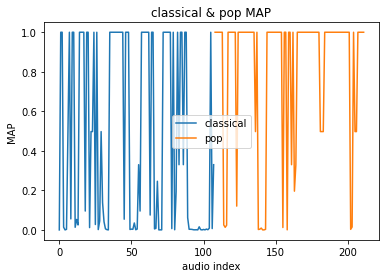

(0.4735302153044552, 0.6813794543113334)

In [227]:
plt.plot([x for x in range(108)], maps_query[0:108], label='classical')
plt.plot([x for x in range(108, 212)], maps_query[108:212],label='pop')
plt.xlabel('audio index')
plt.ylabel('MAP')
plt.title('classical & pop MAP')
plt.legend()
fig = plt.gcf()
fig.savefig('MAP.png')
plt.show()
np.array(maps_query[0:37]).mean(), np.array(maps_query[37:212]).mean()

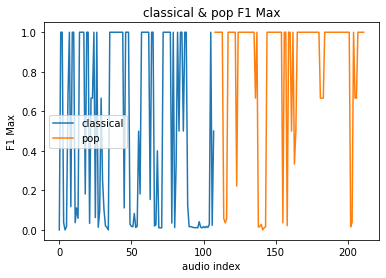

(0.508485083976309, 0.7015872837649143)

In [228]:
plt.plot([x for x in range(108)], max_f_query[0:108], label='classical')
plt.plot([x for x in range(108, 212)], max_f_query[108:212],label='pop')
plt.xlabel('audio index')
plt.ylabel('F1 Max')
plt.title('classical & pop F1 Max')
plt.legend()
fig = plt.gcf()
fig.savefig('F1 Max.png')
plt.show()
np.array(max_f_query[0:37]).mean(), np.array(max_f_query[37:212]).mean()

In [80]:
output_path = 'output.txt'
finger_match(coordinates_query,fanout=fanout, anchor_distance=anchor_distance, output_path=output_path)

Generating Query Hash 1/213...
Query: classical.00000-snippet-10-0
writing to 'output.txt'...
Sorry, the query finger is empty

Generating Query Hash 2/213...
Query: classical.00000-snippet-10-10
writing to 'output.txt'...
Results: classical.00000, classical.00000, classical.00047

Generating Query Hash 3/213...
Query: classical.00000-snippet-10-20
writing to 'output.txt'...
Results: classical.00000, classical.00000, classical.00000

Generating Query Hash 4/213...
Query: classical.00003-snippet-10-0
writing to 'output.txt'...
Results: pop.00002, classical.00059, classical.00099

Generating Query Hash 5/213...
Query: classical.00003-snippet-10-10
writing to 'output.txt'...
Results: classical.00083, classical.00035, classical.00007

Generating Query Hash 6/213...
Query: classical.00003-snippet-10-20
writing to 'output.txt'...
Results: pop.00067, pop.00071, pop.00080

Generating Query Hash 7/213...
Query: classical.00004-snippet-10-0
writing to 'output.txt'...
Results: classical.00004, cl

writing to 'output.txt'...
Results: classical.00068, classical.00096, classical.00088

Generating Query Hash 56/213...
Query: classical.00044-snippet-10-10
writing to 'output.txt'...
Results: classical.00050, classical.00044, classical.00049

Generating Query Hash 57/213...
Query: classical.00044-snippet-10-20
writing to 'output.txt'...
Results: classical.00085, classical.00068, classical.00036

Generating Query Hash 58/213...
Query: classical.00045-snippet-10-0
writing to 'output.txt'...
Results: classical.00045, classical.00045, classical.00045

Generating Query Hash 59/213...
Query: classical.00045-snippet-10-10
writing to 'output.txt'...
Results: classical.00045, classical.00045, classical.00045

Generating Query Hash 60/213...
Query: classical.00045-snippet-10-20
writing to 'output.txt'...
Results: classical.00045, classical.00045, classical.00097

Generating Query Hash 61/213...
Query: classical.00049-snippet-10-0
writing to 'output.txt'...
Results: classical.00049, classical.000

KeyboardInterrupt: 